# Predicting Average Age of First Motherhood

This project investigates whether the data supports this perception: are women, on average, becoming mothers later in life? Specifically, I aim to analyse historical data for the age of first motherhood for women born in a given year and use machine learning techniques to forecast future trends.

The data for this analysis comes from the ONS, first published in 2023 and updated in 2025.

Find the data here: https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/conceptionandfertilityrates/datasets/childbearingforwomenbornindifferentyearsreferencetable

**Before running this notebook**, ensure the file 'final2023tables.xlsx' is uploaded to the session via the 'files' tab.


In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV

## Data Pre-Processing

In [2]:
ons_all = pd.read_excel('final2023tables.xlsx', sheet_name = None)

In [3]:
ons_all['Cover Sheet'] # To read table of contents

,Childbearing statistics for women born in different years,Unnamed: 1
0,Alongside notes and interpreting information s...,NaN
1,Date of publication: 2 April 2025,NaN
2,Childbearing bulletin,NaN
3,Childbearing Quality and methodology informati...,NaN
4,Further information on live births.,NaN
5,Source: Office for National Statistics – Birth...,NaN
6,Table of contents,NaN
7,Name of worksheet,Content of worksheet
8,Terms and Conditions,Detail about accredited official statistics st...
9,Metadata,Information on childbearing for women born in ...


In [4]:
ons_all['Table 2'].head(30) # Project to be carried out using table 2, inspecting for where to choose header

,"Table 2: Cumulative fertility: Proportion of women who have had at least one live birth, age and year of birth of woman, England and Wales, 1920 to 2008 [note 1] [note 2] [note 9]",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32
0,This spreadsheet contains one table. Some cell...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Some cells in this table are blank. These are ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,If you wish to provide feedback on this table ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"This met my needs, please produce it next year",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,I need something slightly different (please sp...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,This isn't what I need at all (please specify),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Year of birth of woman,Age exact years - 16 [note 4],17.00,18.00,19.00,20.00,21.00,22.00,23.00,24.00,...,38.00,39.00,40.00,41.00,42.00,43.00,44.00,45.00,Final,Proportion of women having had no children [no...
7,1920,0,0.00,0.01,0.03,0.07,0.11,0.17,0.25,0.32,...,0.78,0.78,0.79,0.79,0.79,0.79,0.79,0.79,0.79,0.21
8,1921,0,0.00,0.01,0.03,0.07,0.12,0.18,0.26,0.34,...,0.81,0.81,0.81,0.82,0.82,0.82,0.82,0.82,0.82,0.18
9,1922,0,0.00,0.01,0.03,0.06,0.12,0.19,0.27,0.34,...,0.81,0.81,0.81,0.82,0.82,0.82,0.82,0.82,0.82,0.18


In [5]:
proportion_mothers = pd.read_excel('final2023tables.xlsx', sheet_name = 'Table 2', header = 7)
proportion_mothers

,Year of birth of woman,Age exact years - 16 [note 4],17,18,19,20,21,22,23,24,...,38,39,40,41,42,43,44,45,Final,Proportion of women having had no children [note 8]
0,1920,0.0,0.0,0.01,0.03,0.07,0.11,0.17,0.25,0.32,...,0.78,0.78,0.79,0.79,0.79,0.79,0.79,0.79,0.79,0.21
1,1921,0.0,0.0,0.01,0.03,0.07,0.12,0.18,0.26,0.34,...,0.81,0.81,0.81,0.82,0.82,0.82,0.82,0.82,0.82,0.18
2,1922,0.0,0.0,0.01,0.03,0.06,0.12,0.19,0.27,0.34,...,0.81,0.81,0.81,0.82,0.82,0.82,0.82,0.82,0.82,0.18
3,1923,0.0,0.0,0.01,0.03,0.06,0.12,0.19,0.27,0.36,...,0.82,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.84,0.16
4,1924,0.0,0.0,0.01,0.03,0.07,0.12,0.19,0.28,0.40,...,0.82,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2004,0.0,0.0,0.01,0.02,0.04,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,2005,0.0,0.0,0.01,0.02,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,2006,0.0,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,2007,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
proportion_mothers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 33 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Year of birth of woman                               89 non-null     int64  
 1   Age exact years - 16 [note 4]                        89 non-null     float64
 2   17                                                   88 non-null     float64
 3   18                                                   87 non-null     float64
 4   19                                                   86 non-null     float64
 5   20                                                   85 non-null     float64
 6   21                                                   84 non-null     float64
 7   22                                                   83 non-null     float64
 8   23                                                   82 non-null     flo

### NaN Values
The data has been collected 1920-2008 with the minimum age being 16 and maximum 45.

This means that not all birth cohorts have reached all ages. 1979 is the last cohort to have completed all 45 years and so there are 59 complete rows.

For years after 1979 the number of NaN values for each age column increases by one each year, since one new birth cohort fails to meet the threshold each year.

This data is necessarily missing and therefore not replaced at this time.*italicised text*

### Data Types

Proportions are floats and birth years integers which is appropriate.

In [7]:
proportion_mothers.columns

for col in proportion_mothers.columns:
  print({col: type(col)})

{'Year of birth of woman': <class 'str'>}
{'Age exact years - 16 [note 4]': <class 'str'>}
{'17': <class 'str'>}
{'18': <class 'str'>}
{'19': <class 'str'>}
{'20': <class 'str'>}
{'21': <class 'str'>}
{'22': <class 'str'>}
{'23': <class 'str'>}
{'24': <class 'str'>}
{'25': <class 'str'>}
{'26': <class 'str'>}
{'27': <class 'str'>}
{'28': <class 'str'>}
{'29': <class 'str'>}
{'30': <class 'str'>}
{'31': <class 'str'>}
{'32': <class 'str'>}
{'33': <class 'str'>}
{'34': <class 'str'>}
{'35': <class 'str'>}
{'36': <class 'str'>}
{'37': <class 'str'>}
{'38': <class 'str'>}
{'39': <class 'str'>}
{'40': <class 'str'>}
{'41': <class 'str'>}
{'42': <class 'str'>}
{'43': <class 'str'>}
{'44': <class 'str'>}
{'45': <class 'str'>}
{'Final': <class 'str'>}
{'Proportion of women having had no children [note 8]': <class 'str'>}


In [8]:
# Converting ages str to int & renaming others for efficiency

def convert_col_name(col):
  if col.isdigit():
    return int(col)
  elif col == 'Age exact years - 16 [note 4]':
    return(16)
  elif col == 'Year of birth of woman':
    return('Birth Year')
  elif col == 'Proportion of women having had no children [note 8]':
    return('Proportion Childless')
  else:
    return col

proportion_mothers.columns = [convert_col_name(col) for col in proportion_mothers.columns]

proportion_mothers

,Birth Year,16,17,18,19,20,21,22,23,24,...,38,39,40,41,42,43,44,45,Final,Proportion Childless
0,1920,0.0,0.0,0.01,0.03,0.07,0.11,0.17,0.25,0.32,...,0.78,0.78,0.79,0.79,0.79,0.79,0.79,0.79,0.79,0.21
1,1921,0.0,0.0,0.01,0.03,0.07,0.12,0.18,0.26,0.34,...,0.81,0.81,0.81,0.82,0.82,0.82,0.82,0.82,0.82,0.18
2,1922,0.0,0.0,0.01,0.03,0.06,0.12,0.19,0.27,0.34,...,0.81,0.81,0.81,0.82,0.82,0.82,0.82,0.82,0.82,0.18
3,1923,0.0,0.0,0.01,0.03,0.06,0.12,0.19,0.27,0.36,...,0.82,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.84,0.16
4,1924,0.0,0.0,0.01,0.03,0.07,0.12,0.19,0.28,0.40,...,0.82,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2004,0.0,0.0,0.01,0.02,0.04,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,2005,0.0,0.0,0.01,0.02,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,2006,0.0,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,2007,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Childless column not necessary for this analysis, dropping the column in this version

mother_df = proportion_mothers.drop('Proportion Childless', axis=1)
mother_df

,Birth Year,16,17,18,19,20,21,22,23,24,...,37,38,39,40,41,42,43,44,45,Final
0,1920,0.0,0.0,0.01,0.03,0.07,0.11,0.17,0.25,0.32,...,0.77,0.78,0.78,0.79,0.79,0.79,0.79,0.79,0.79,0.79
1,1921,0.0,0.0,0.01,0.03,0.07,0.12,0.18,0.26,0.34,...,0.80,0.81,0.81,0.81,0.82,0.82,0.82,0.82,0.82,0.82
2,1922,0.0,0.0,0.01,0.03,0.06,0.12,0.19,0.27,0.34,...,0.80,0.81,0.81,0.81,0.82,0.82,0.82,0.82,0.82,0.82
3,1923,0.0,0.0,0.01,0.03,0.06,0.12,0.19,0.27,0.36,...,0.82,0.82,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.84
4,1924,0.0,0.0,0.01,0.03,0.07,0.12,0.19,0.28,0.40,...,0.82,0.82,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2004,0.0,0.0,0.01,0.02,0.04,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,2005,0.0,0.0,0.01,0.02,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,2006,0.0,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,2007,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Sense check that all proportion values are less than or equal to 1 & so valid proportions

proportions = mother_df.drop('Birth Year', axis=1)

valid = ((proportions <= 1) | proportions.isna()).all().all()

print(valid)

True


## Exploratory Data Analysis

In [11]:
mother_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Birth Year  89 non-null     int64  
 1   16          89 non-null     float64
 2   17          88 non-null     float64
 3   18          87 non-null     float64
 4   19          86 non-null     float64
 5   20          85 non-null     float64
 6   21          84 non-null     float64
 7   22          83 non-null     float64
 8   23          82 non-null     float64
 9   24          81 non-null     float64
 10  25          80 non-null     float64
 11  26          79 non-null     float64
 12  27          78 non-null     float64
 13  28          77 non-null     float64
 14  29          76 non-null     float64
 15  30          75 non-null     float64
 16  31          74 non-null     float64
 17  32          73 non-null     float64
 18  33          72 non-null     float64
 19  34          71 non-null     flo

In [12]:
mother_df.describe()

,Birth Year,16,17,18,19,20,21,22,23,24,...,37,38,39,40,41,42,43,44,45,Final
count,89.000000,89.000000,88.000000,87.000000,86.000000,85.000000,84.000000,83.000000,82.000000,81.000000,...,68.000000,67.000000,66.000000,65.000000,64.000000,63.000000,62.000000,61.000000,60.000000,59.000000
mean,1964.000000,0.000225,0.010341,0.032299,0.066628,0.112706,0.167381,0.226747,0.288537,0.348765,...,0.813235,0.822090,0.828939,0.834462,0.838281,0.841270,0.842742,0.843115,0.843833,0.844915
std,25.836021,0.001491,0.008087,0.015679,0.028143,0.039503,0.052253,0.067266,0.085304,0.103046,...,0.045300,0.041251,0.037871,0.035046,0.033312,0.032254,0.031941,0.031809,0.032264,0.031914
min,1920.000000,0.000000,0.000000,0.010000,0.020000,0.040000,0.060000,0.080000,0.110000,0.150000,...,0.760000,0.770000,0.780000,0.780000,0.790000,0.790000,0.790000,0.790000,0.790000,0.790000
25%,1942.000000,0.000000,0.000000,0.020000,0.040000,0.090000,0.150000,0.195000,0.240000,0.280000,...,0.770000,0.780000,0.800000,0.810000,0.810000,0.815000,0.820000,0.820000,0.820000,0.820000
50%,1964.000000,0.000000,0.010000,0.040000,0.070000,0.120000,0.165000,0.210000,0.270000,0.330000,...,0.805000,0.810000,0.820000,0.830000,0.830000,0.840000,0.840000,0.840000,0.840000,0.840000
75%,1986.000000,0.000000,0.020000,0.040000,0.080000,0.130000,0.182500,0.265000,0.347500,0.430000,...,0.852500,0.860000,0.867500,0.870000,0.870000,0.870000,0.870000,0.870000,0.872500,0.875000
max,2008.000000,0.010000,0.020000,0.060000,0.120000,0.200000,0.270000,0.350000,0.440000,0.520000,...,0.900000,0.900000,0.900000,0.900000,0.910000,0.910000,0.910000,0.910000,0.910000,0.910000


<ipython-input-13-1131334898>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


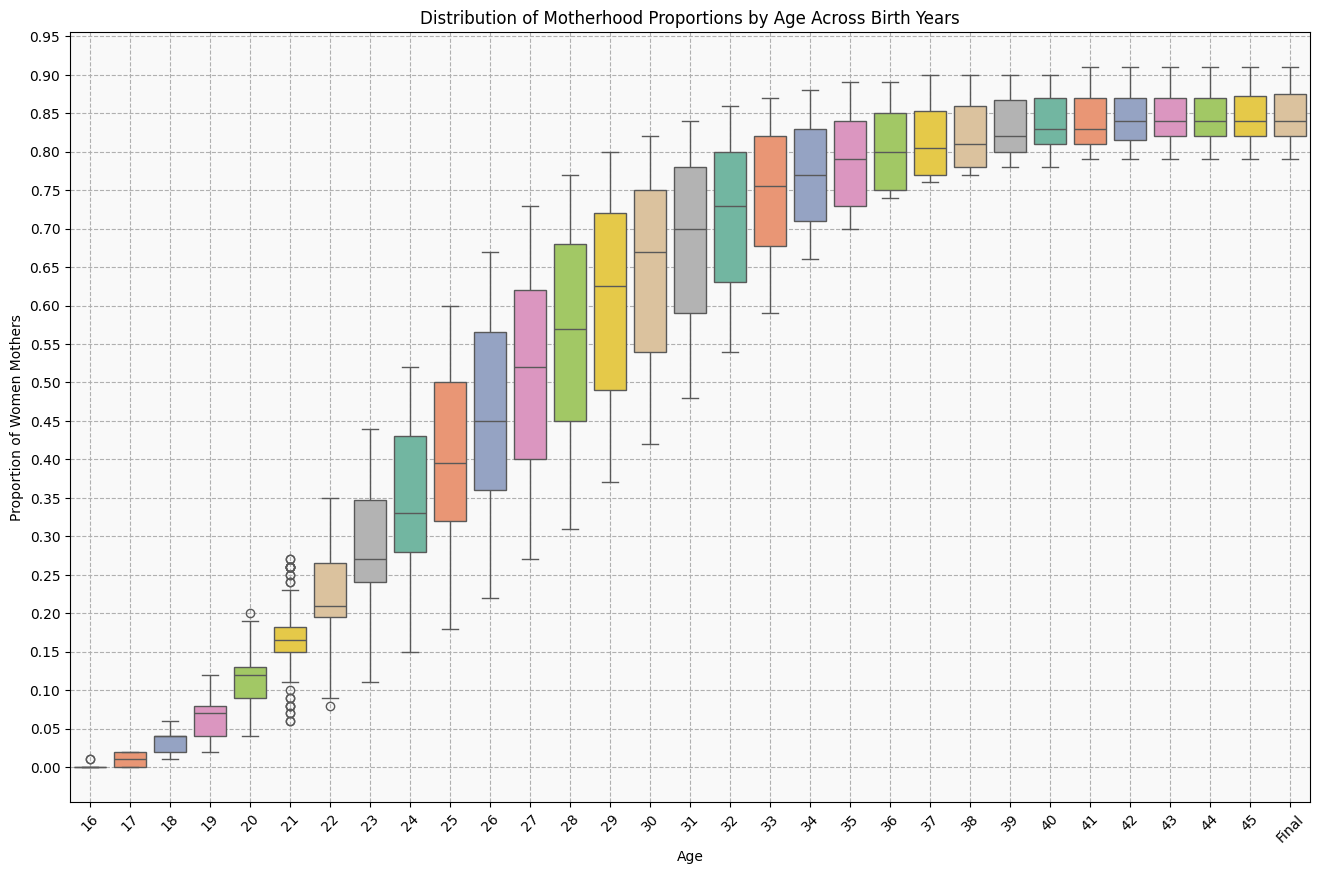

In [13]:
# To show distribution of proportions at each age

melt_df = mother_df.melt(id_vars = 'Birth Year', var_name = 'Age', value_name = 'Proportion')

plt.figure(figsize=(16, 10))
plt.rcParams['axes.facecolor'] = '#f9f9f9'

sns.boxplot(
    data = melt_df,
    x = 'Age',
    y = 'Proportion',
    palette='Set2')

yscl = np.arange(0, 1, 0.05)
plt.yticks(yscl)
plt.xticks(rotation=45)
plt.grid(linestyle = '--')

plt.xlabel('Age')
plt.ylabel('Proportion of Women Mothers')
plt.title('Distribution of Motherhood Proportions by Age Across Birth Years')

plt.show()

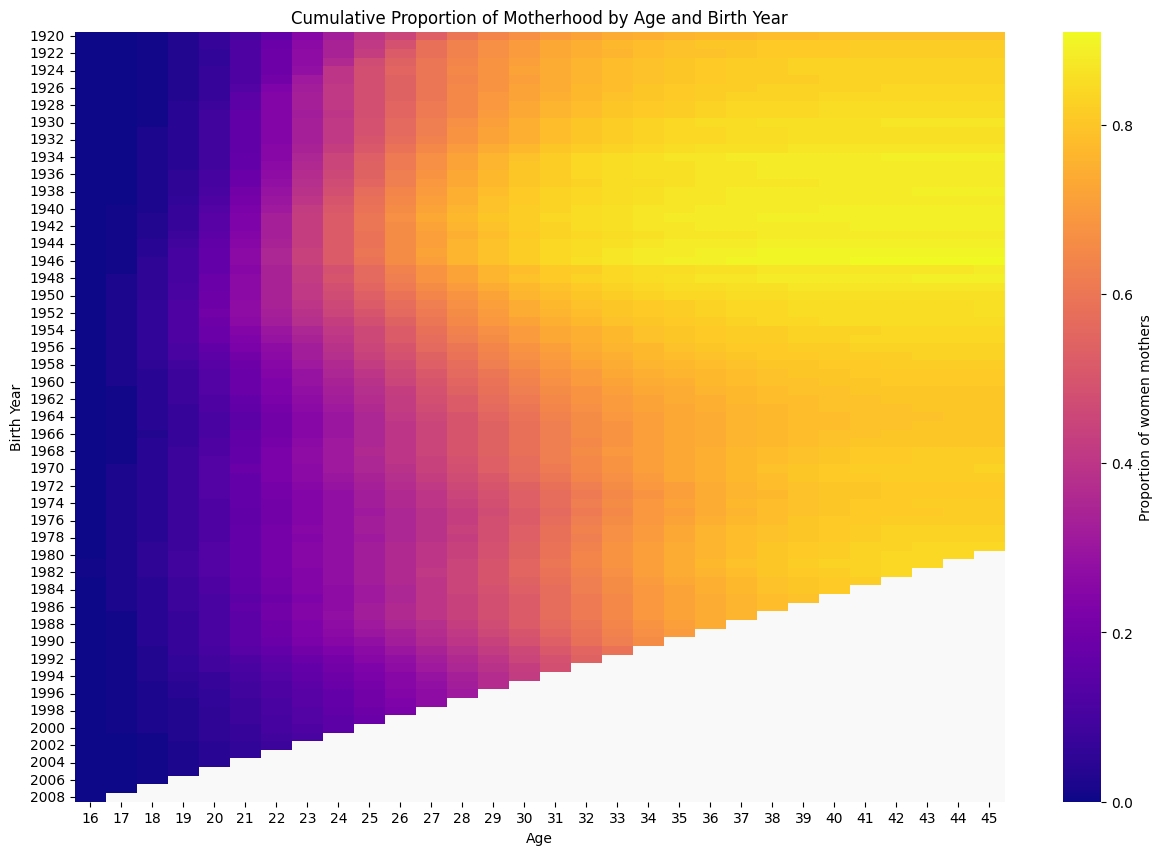

In [14]:
# To show proportion of women becoming mothers by age and birth year

age_df = mother_df.drop(columns='Final').set_index('Birth Year') # want age only data not final

plt.figure(figsize = (15, 10))

sns.heatmap(age_df,
            cmap='plasma',
            cbar_kws={'label': 'Proportion of women mothers'})

plt.title('Cumulative Proportion of Motherhood by Age and Birth Year')
plt.xlabel('Age')
plt.ylabel('Birth Year')

plt.show()

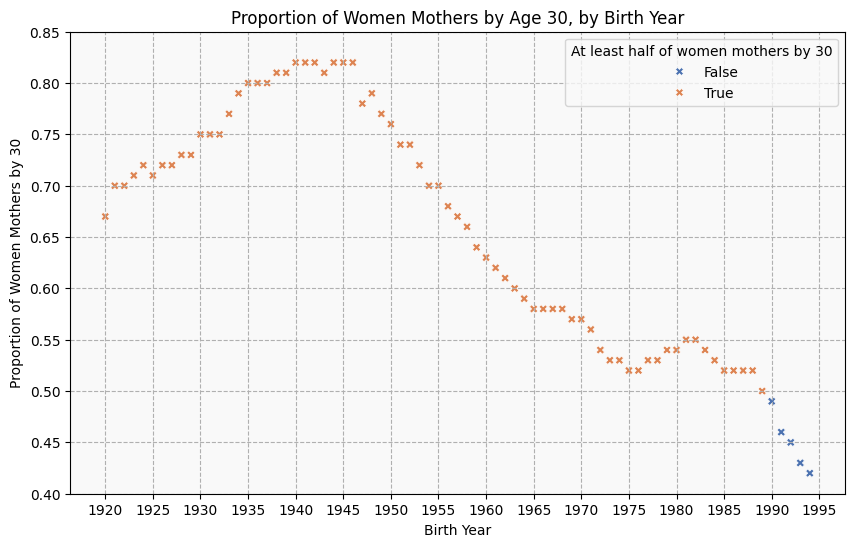

In [15]:
# To show imbalance in birthyears where proportion of women mothers at 30 is >= 0.5

plt.figure(figsize=(10,6))

sns.scatterplot(
    data = mother_df,
    x = mother_df['Birth Year'],
    y = mother_df[30],
    marker = 'X',
    hue = mother_df[30] >= 0.5,
    palette = 'deep')

plt.grid(linestyle='--')
xscl = np.arange(1920, 2000, 5)
yscl = np.arange(0.4, 0.9, 0.05)
plt.xticks(xscl)
plt.yticks(yscl)

plt.xlabel('Birth Year')
plt.ylabel('Proportion of Women Mothers by 30')
plt.title('Proportion of Women Mothers by Age 30, by Birth Year')
plt.legend(title = 'At least half of women mothers by 30')

plt.show()

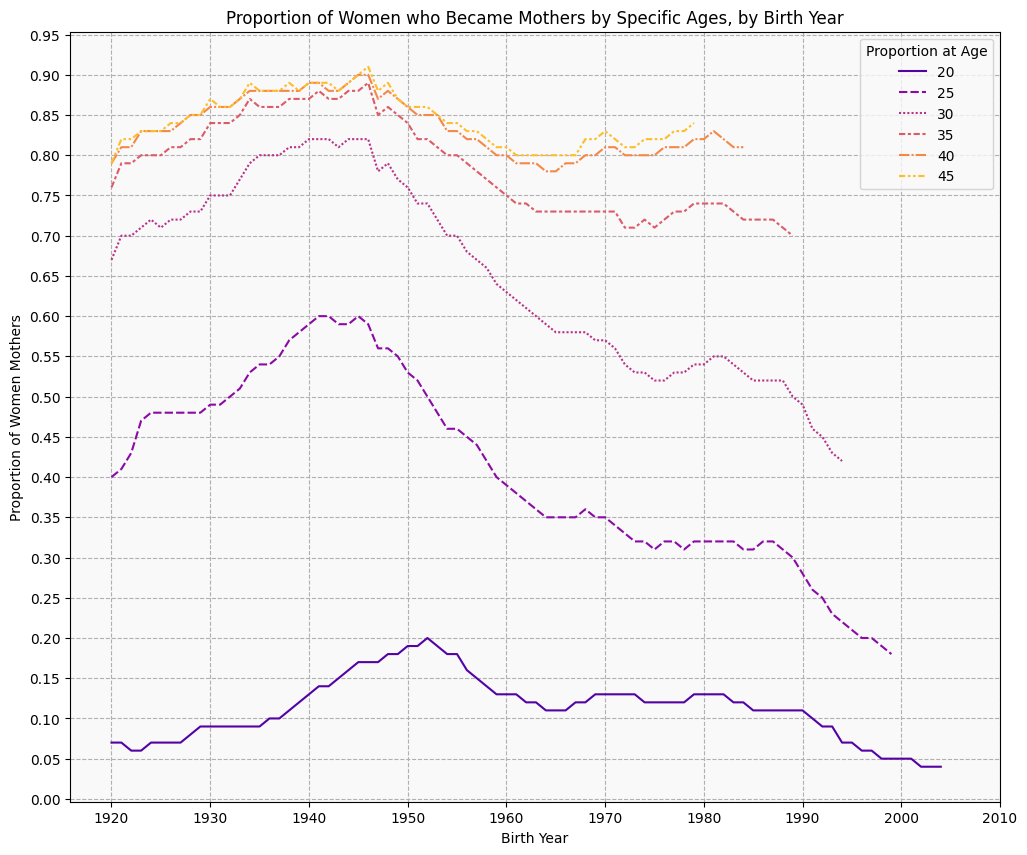

In [16]:
# To show trend in proportion of mothers at 5 year intervals by birth year

ints_df = mother_df[['Birth Year', 20, 25, 30, 35, 40, 45]].set_index('Birth Year')

plt.figure(figsize=(12,10))

sns.lineplot(data = ints_df, palette = 'plasma')

plt.grid(linestyle='--')
xscl = np.arange(1920, 2015, 10)
yscl = np.arange(0, 1, 0.05)
plt.xticks(xscl)
plt.yticks(yscl)

plt.xlabel('Birth Year')
plt.ylabel('Proportion of Women Mothers')
plt.title('Proportion of Women who Became Mothers by Specific Ages, by Birth Year')
plt.legend(title = 'Proportion at Age')

plt.show()

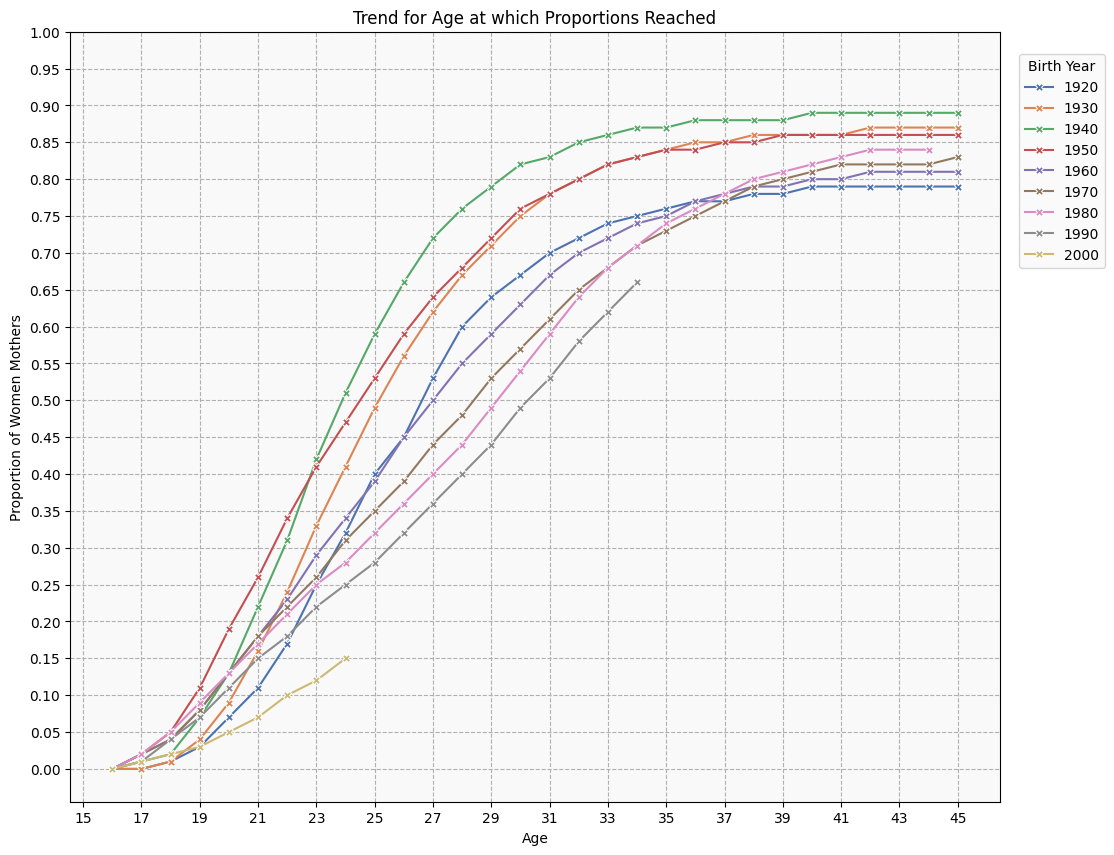

In [17]:
# To show trend in age at which proportions are reached over 10 yr intervals in birth year

ten_yrs = np.arange(1920, 2010, 10)
tens_df = mother_df[mother_df['Birth Year'].isin(ten_yrs)].drop('Final', axis=1)


melted = tens_df.melt(id_vars = 'Birth Year', var_name = 'Age', value_name = 'Proportion')


melted['Age'] = melted['Age'].astype(int)

plt.figure(figsize=(12, 10))

sns.lineplot(
    data = melted,
    x = 'Age',
    y = 'Proportion',
    hue = 'Birth Year',
    palette = 'deep',
    marker = 'X'
)

plt.grid(linestyle='--')
plt.yticks(np.arange(0, 1.05, 0.05))
plt.xticks(np.arange(15, 46, 2))

plt.ylabel('Proportion of Women Mothers')
plt.xlabel('Age')
plt.title('Trend for Age at which Proportions Reached')

plt.legend(
    title ='Birth Year',
    loc = 'upper right',
    bbox_to_anchor = (1.12, 0.98))

plt.show()

In [18]:
# Preparing new dataframe to show ages at which proportion of mothers reaches 25%, 50% & 75% by birth year

props_df = mother_df.drop('Final', axis=1)

melt_df = props_df.melt(id_vars = 'Birth Year', var_name = 'Age', value_name = 'Proportion')

melt_df['Age'] = melt_df['Age'].astype(int)

quarters = []

for year in melt_df['Birth Year']:
  this_yr = melt_df[melt_df['Birth Year'] == year].sort_values('Age')

  age_25 = this_yr[this_yr['Proportion'] >= 0.25]['Age'].min()
  age_50 = this_yr[this_yr['Proportion'] >= 0.5]['Age'].min()
  age_75 = this_yr[this_yr['Proportion'] >= 0.75]['Age'].min()

  quarters.append({
        'Birth Year': year,
        '25% at': age_25,
        '50% at': age_50,
        '75% at': age_75
    })

quarters_df = pd.DataFrame(quarters).set_index('Birth Year')

quarters_df

,25% at,50% at,75% at
Birth Year,,,
1920,23.0,27.0,34.0
1921,23.0,27.0,32.0
1922,23.0,26.0,32.0
1923,23.0,26.0,32.0
1924,23.0,26.0,32.0
...,...,...,...
2004,NaN,NaN,NaN
2005,NaN,NaN,NaN
2006,NaN,NaN,NaN


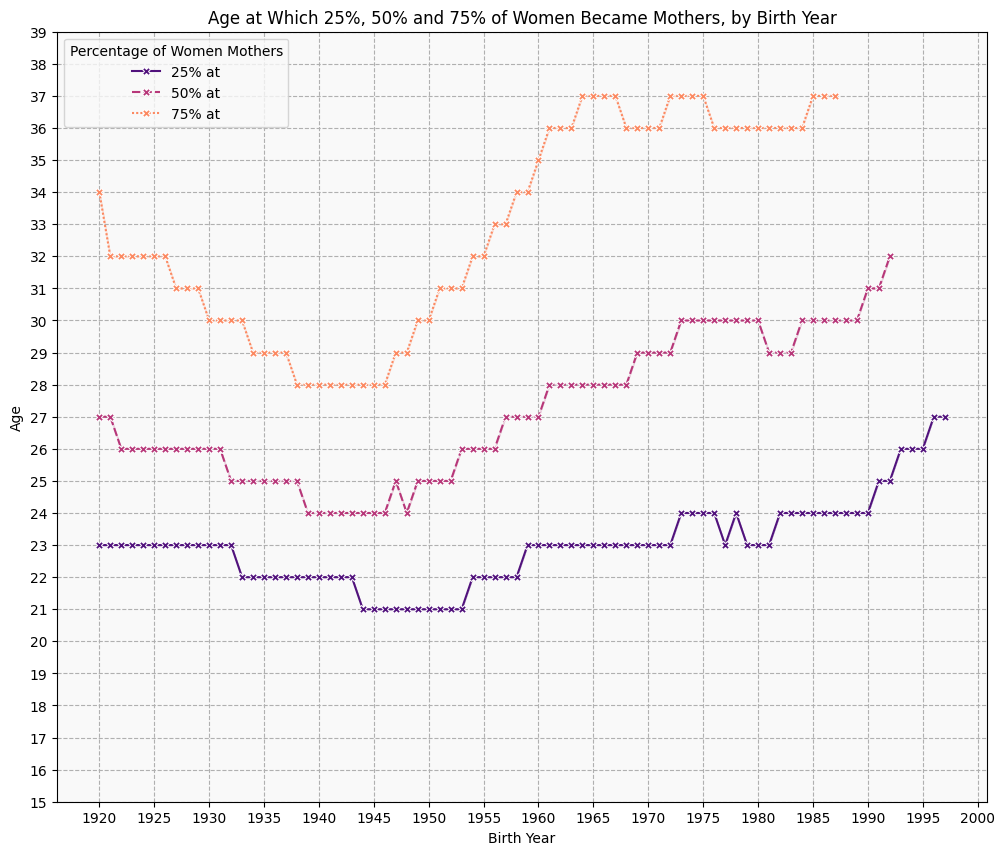

In [19]:
# To show trend in ages at which the proportion of mothers reaches reaches 25%, 50% & 75% by birth year


plt.figure(figsize=(12,10))

sns.lineplot(
    data = quarters_df,
    marker = 'X',
    palette = 'magma')

plt.grid(linestyle='--')
xscl = np.arange(1920, 2005, 5)
yscl = np.arange(15, 40, 1)
plt.xticks(xscl)
plt.yticks(yscl)

plt.xlabel('Birth Year')
plt.ylabel('Age')
plt.title('Age at Which 25%, 50% and 75% of Women Became Mothers, by Birth Year')
plt.legend(title = 'Percentage of Women Mothers')

plt.show()

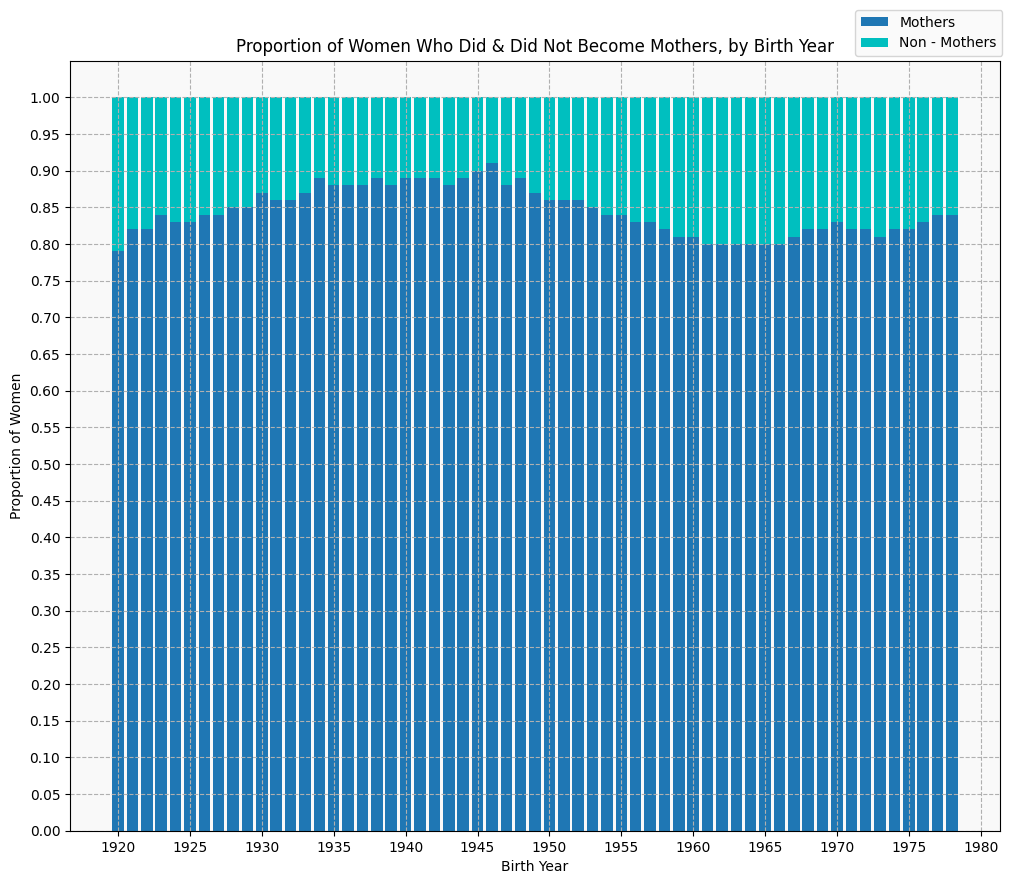

In [20]:
# To show change in final proportion of women becoming mothers vs not

fnl_df = mother_df.set_index('Birth Year')
fnl_df

fnl_df['Non-Mothers'] = [ 1 - p for p in fnl_df['Final']]
fnl_df

plt.figure(figsize=(12,10))

birth_year = fnl_df.index
mothers = fnl_df['Final']
non_mothers = fnl_df['Non-Mothers']

plt.bar(birth_year,mothers, label = 'Mothers', color = 'tab:blue')
plt.bar(birth_year, non_mothers, bottom = mothers, label = 'Non - Mothers', color = 'c')

plt.grid(linestyle='--')
xscl = np.arange(1920, 1985, 5)
yscl = np.arange(0, 1.05, 0.05)
plt.xticks(xscl)
plt.yticks(yscl)

plt.xlabel('Birth Year')
plt.ylabel('Proportion of Women')
plt.title('Proportion of Women Who Did & Did Not Become Mothers, by Birth Year')
plt.legend(bbox_to_anchor = (1.01,1.075))

plt.show()

In [21]:
# Preparing dataframe for Demidecades mean graph

mother_df

demis = []

for i in range(0, 90, 5):
  low = 1920 + i
  high = 1926 + i
  label = f'From {low}'
  cohort = mother_df[mother_df['Birth Year'].isin(range(low, high, 1))]

  vals = cohort.mean(numeric_only = True)
  vals['Demidecade'] = label
  demis.append(vals)

demis_df = pd.DataFrame(demis)

demis_df

,Birth Year,16,17,18,19,20,21,22,23,24,...,38,39,40,41,42,43,44,45,Final,Demidecade
0,1922.5,0.000000,0.000000,0.010000,0.030000,0.066667,0.118333,0.186667,0.273333,0.360000,...,0.810000,0.813333,0.816667,0.820000,0.820000,0.820000,0.820000,0.820000,0.821667,From 1920
1,1927.5,0.000000,0.000000,0.010000,0.035000,0.078333,0.145000,0.231667,0.323333,0.406667,...,0.836667,0.836667,0.843333,0.843333,0.846667,0.846667,0.846667,0.846667,0.846667,From 1925
2,1932.5,0.000000,0.000000,0.018333,0.040000,0.090000,0.163333,0.246667,0.340000,0.426667,...,0.863333,0.868333,0.868333,0.868333,0.871667,0.871667,0.871667,0.871667,0.871667,From 1930
3,1937.5,0.000000,0.001667,0.020000,0.053333,0.108333,0.193333,0.285000,0.386667,0.478333,...,0.878333,0.878333,0.881667,0.881667,0.881667,0.883333,0.883333,0.883333,0.883333,From 1935
4,1942.5,0.000000,0.010000,0.031667,0.080000,0.148333,0.238333,0.331667,0.430000,0.518333,...,0.886667,0.886667,0.888333,0.890000,0.890000,0.890000,0.890000,0.890000,0.890000,From 1940
5,1947.5,0.000000,0.015000,0.048333,0.103333,0.176667,0.258333,0.343333,0.423333,0.496667,...,0.876667,0.880000,0.880000,0.881667,0.881667,0.883333,0.883333,0.885000,0.885000,From 1945
6,1952.5,0.000000,0.020000,0.058333,0.118333,0.188333,0.255000,0.320000,0.378333,0.436667,...,0.835000,0.843333,0.845000,0.846667,0.848333,0.848333,0.848333,0.851667,0.851667,From 1950
7,1957.5,0.000000,0.020000,0.051667,0.098333,0.148333,0.200000,0.256667,0.311667,0.370000,...,0.803333,0.808333,0.813333,0.818333,0.821667,0.823333,0.823333,0.823333,0.823333,From 1955
8,1962.5,0.000000,0.011667,0.040000,0.075000,0.120000,0.165000,0.215000,0.266667,0.316667,...,0.776667,0.783333,0.788333,0.793333,0.796667,0.800000,0.801667,0.801667,0.801667,From 1960
9,1967.5,0.000000,0.011667,0.038333,0.075000,0.120000,0.165000,0.211667,0.260000,0.306667,...,0.776667,0.786667,0.795000,0.803333,0.805000,0.810000,0.810000,0.811667,0.813333,From 1965


In [22]:
# Also taking mean over 5 year age intervals

age_df = demis_df.copy()

age_cols = [col for col in age_df.columns if str(col).isdigit()]

age_cols = sorted([int(col) for col in age_cols])

bins = [(start, start + 4) for start in range(16, 46, 5)]

for start, end in bins:
  bin_cols = [age for age in range(start, end+1)]
  col_name = f'{start} - {end}'
  age_df[col_name] = age_df[bin_cols].mean(axis=1)

final_df = age_df[['Birth Year', 'Demidecade'] + [f'{start} - {start+4}' for start in range(16, 46, 5)]]

final_df

,Birth Year,Demidecade,16 - 20,21 - 25,26 - 30,31 - 35,36 - 40,41 - 45
0,1922.5,From 1920,0.021333,0.276667,0.620000,0.763667,0.808667,0.820000
1,1927.5,From 1925,0.024667,0.317667,0.644667,0.790000,0.835333,0.846000
2,1932.5,From 1930,0.029667,0.337333,0.685000,0.827333,0.863000,0.871000
3,1937.5,From 1935,0.036667,0.381000,0.730333,0.848333,0.877000,0.882667
4,1942.5,From 1940,0.054000,0.422667,0.749667,0.857667,0.884333,0.890000
5,1947.5,From 1945,0.068667,0.417333,0.716667,0.840333,0.875000,0.883000
6,1952.5,From 1950,0.077000,0.376333,0.644667,0.787667,0.836000,0.848667
7,1957.5,From 1955,0.063667,0.313000,0.577000,0.740667,0.801667,0.822000
8,1962.5,From 1960,0.049333,0.266000,0.517667,0.695667,0.773333,0.798667
9,1967.5,From 1965,0.049000,0.259000,0.490667,0.679000,0.773667,0.808000


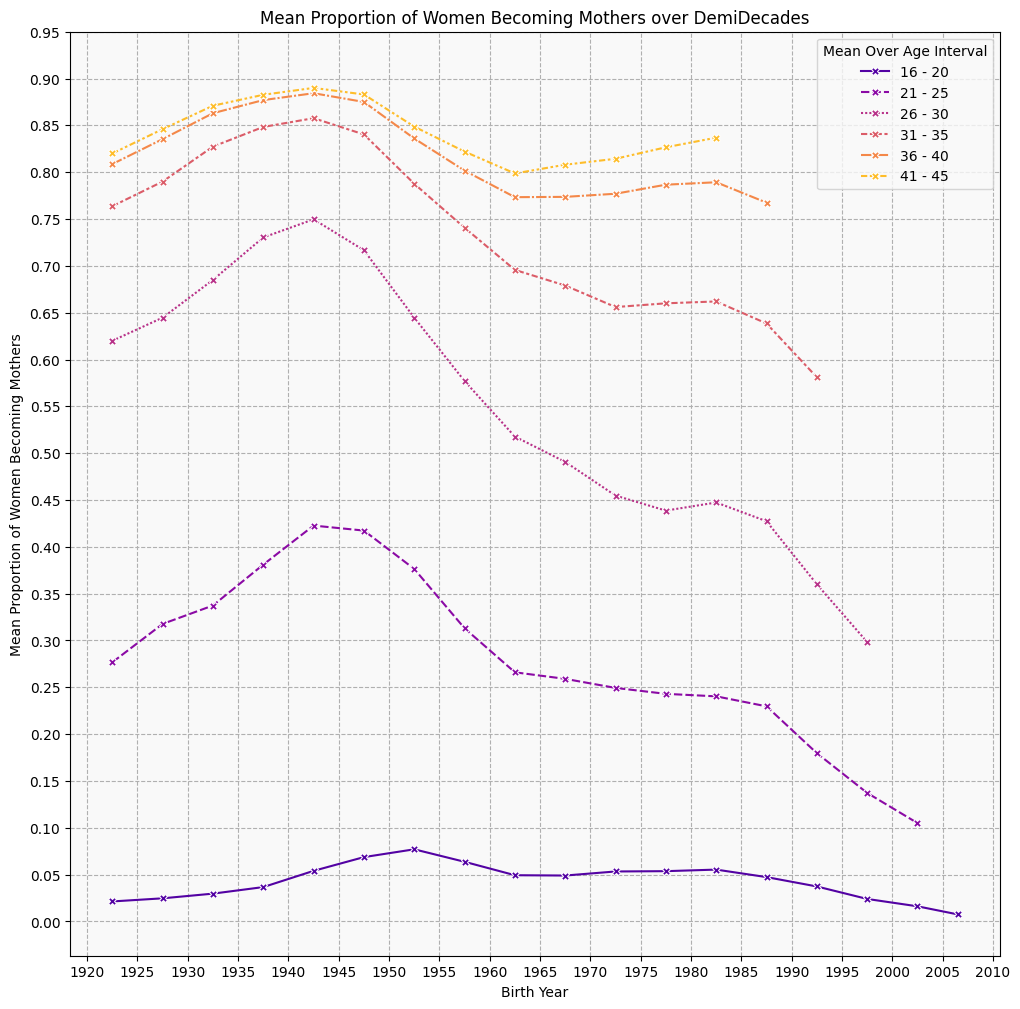

In [23]:
grph_df = final_df.drop('Demidecade', axis = 1).set_index('Birth Year')
grph_df

plt.figure(figsize=(12,12))

sns.lineplot(
    data = grph_df,
    marker = 'X',
    palette = 'plasma')

plt.grid(linestyle='--')
xscl = np.arange(1920, 2015, 5)
yscl = np.arange(0, 1, 0.05)
plt.xticks(xscl)
plt.yticks(yscl)

plt.xlabel('Birth Year')
plt.ylabel('Mean Proportion of Women Becoming Mothers')
plt.title('Mean Proportion of Women Becoming Mothers over DemiDecades')
plt.legend(title = 'Mean Over Age Interval')

plt.show()

# ASSIGNMENT 2

# Data Splitting Strategy

In [24]:
# For the training set, it is essential that the 50% threshold haas been reached.
# Adding column 50_reached to explicitly filter by this condition.

ages = [col for col in mother_df.columns if str(col).isdigit()]
mother_df[ages]

mother_df['Max'] = mother_df[ages].max(axis = 1)

reached_half = mother_df['Max'] >= 0.5

mother_df['50_reached'] = reached_half

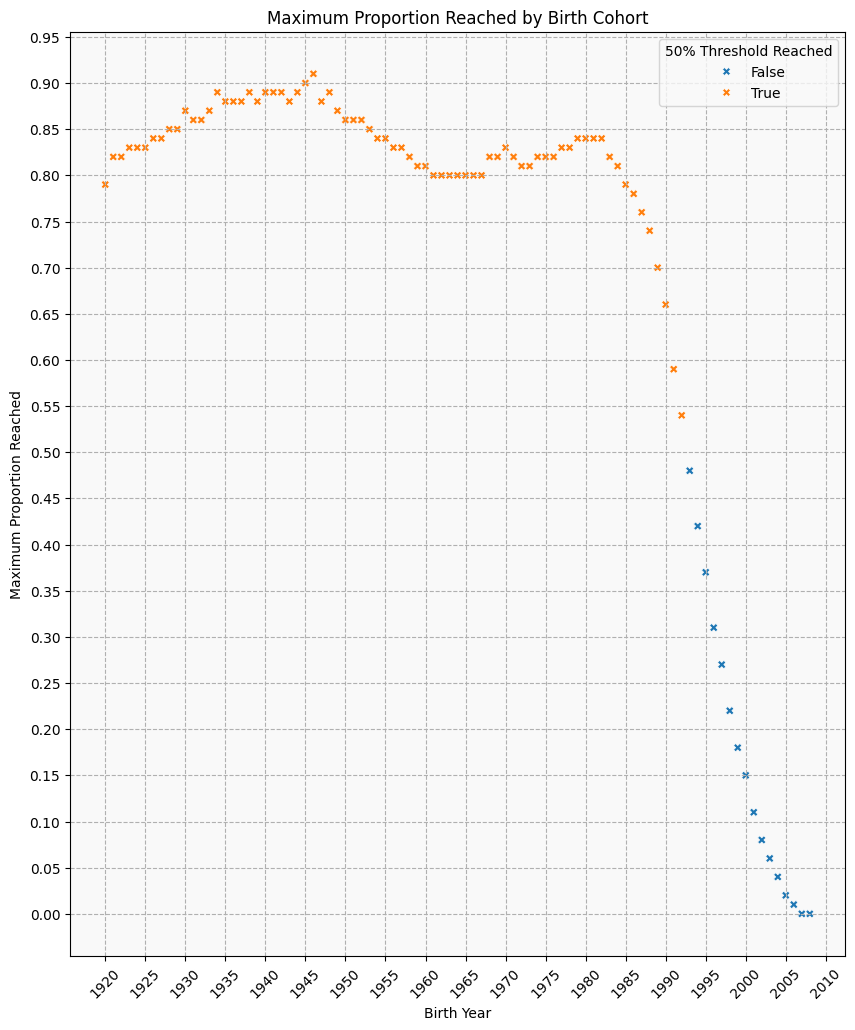

In [25]:
# Plotting the max proportion

plt.figure(figsize = (10, 12))
sns.scatterplot(
    x = mother_df['Birth Year'],
    y = mother_df['Max'],
    hue = mother_df['50_reached'],
    marker = 'X'
)

plt.grid(linestyle = '--')
plt.xticks(np.arange(1920, 2015, 5), rotation = 45)
plt.yticks(np.arange(0, 1, 0.05))

plt.xlabel('Birth Year')
plt.ylabel('Maximum Proportion Reached')
plt.legend(title = '50% Threshold Reached')
plt.title('Maximum Proportion Reached by Birth Cohort')
plt.show()

In [79]:
# Quick maths to investigate train/validate/test percentages

all = 2008 - 1920

train = 1975 - 1920

val = 1989 - 1975

test = 2008 - 1989

checkable_test = 1992 - 1989

forecasts = 2008 - 1992

slices = train/all, val/all, checkable_test/all, forecasts/all
slices

(0.625, 0.1590909090909091, 0.03409090909090909, 0.18181818181818182)

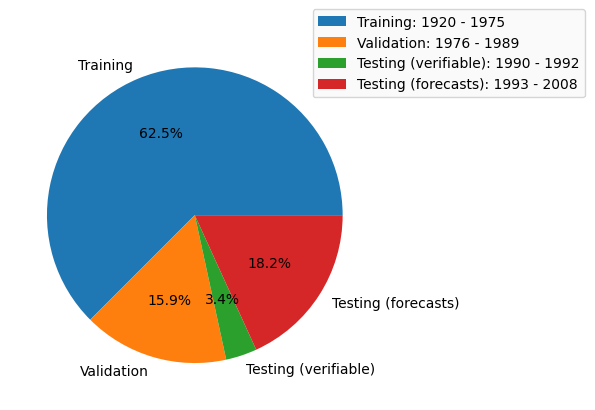

In [80]:
# Plotting the split proportions

plt.pie(
    x = slices,
    labels = ['Training', 'Validation', 'Testing (verifiable)', 'Testing (forecasts)'],
    autopct = '%1.1f%%'
)

set_labels = ['Training: 1920 - 1975',
              'Validation: 1976 - 1989',
              'Testing (verifiable): 1990 - 1992',
              'Testing (forecasts): 1993 - 2008']

plt.legend(labels = set_labels, bbox_to_anchor=(0.8, 0.8))
plt.show()

# Feature Engineering

As explored in the report, all features are calculated within individual birth cohorts so there is no data leakage when feature engineering is performed before splitting the data into training, validation and testing sets.

#### Target Variable:

Age at which 50% of the birth cohort have become mothers.

#### Input Features:
1. Year of birth
2. Age at 25% motherhood
3. Change in proportion (age 20-25)
4. Change in age (25%-35%)
5. Change in age (35%-45%)

In [28]:
mother_df.head(10)

,Birth Year,16,17,18,19,20,21,22,23,24,...,39,40,41,42,43,44,45,Final,Max,50_reached
0,1920,0.0,0.0,0.01,0.03,0.07,0.11,0.17,0.25,0.32,...,0.78,0.79,0.79,0.79,0.79,0.79,0.79,0.79,0.79,True
1,1921,0.0,0.0,0.01,0.03,0.07,0.12,0.18,0.26,0.34,...,0.81,0.81,0.82,0.82,0.82,0.82,0.82,0.82,0.82,True
2,1922,0.0,0.0,0.01,0.03,0.06,0.12,0.19,0.27,0.34,...,0.81,0.81,0.82,0.82,0.82,0.82,0.82,0.82,0.82,True
3,1923,0.0,0.0,0.01,0.03,0.06,0.12,0.19,0.27,0.36,...,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.84,0.83,True
4,1924,0.0,0.0,0.01,0.03,0.07,0.12,0.19,0.28,0.40,...,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.83,True
5,1925,0.0,0.0,0.01,0.03,0.07,0.12,0.20,0.31,0.40,...,0.82,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.83,True
6,1926,0.0,0.0,0.01,0.03,0.07,0.13,0.23,0.32,0.41,...,0.83,0.83,0.83,0.84,0.84,0.84,0.84,0.84,0.84,True
7,1927,0.0,0.0,0.01,0.03,0.07,0.15,0.24,0.33,0.41,...,0.83,0.84,0.84,0.84,0.84,0.84,0.84,0.84,0.84,True
8,1928,0.0,0.0,0.01,0.04,0.08,0.15,0.24,0.33,0.41,...,0.84,0.85,0.85,0.85,0.85,0.85,0.85,0.85,0.85,True
9,1929,0.0,0.0,0.01,0.04,0.09,0.16,0.24,0.32,0.40,...,0.84,0.85,0.85,0.85,0.85,0.85,0.85,0.85,0.85,True


In [29]:
# Modifying proportions dataframe for 25%, 35%, 45%, slopes and 50% target

props_df = mother_df.drop(['Final', 'Max', '50_reached'], axis=1)

melt_df = props_df.melt(id_vars = 'Birth Year', var_name = 'Age', value_name = 'Proportion')

melt_df['Age'] = melt_df['Age'].astype(int)

prop_slope = []

for year in melt_df['Birth Year']:
  this_yr = melt_df[melt_df['Birth Year'] == year].sort_values('Age')

  age_25 = this_yr[this_yr['Proportion'] >= 0.25]['Age'].min()
  age_35 = this_yr[this_yr['Proportion'] >= 0.35]['Age'].min()
  age_45 = this_yr[this_yr['Proportion'] >= 0.45]['Age'].min()
  age_50 = this_yr[this_yr['Proportion'] >= 0.5]['Age'].min()

  prop_slope.append({
        'Birth Year': year,
        'age_25%': age_25,
        'age_35%': age_35,
        'age_45%': age_45,
        'age_50%': age_50
    })

prop_slope_df = pd.DataFrame(prop_slope)

prop_slope_df.head()

,Birth Year,age_25%,age_35%,age_45%,age_50%
0,1920,23.0,25.0,26.0,27.0
1,1921,23.0,25.0,26.0,27.0
2,1922,23.0,25.0,26.0,26.0
3,1923,23.0,24.0,25.0,26.0
4,1924,23.0,24.0,25.0,26.0


In [30]:
# Defining difference function for changes in age and proportion

def find_diff(data, bottom, top):
  diff = data[top] - data[bottom]
  return diff

In [31]:
prop_slope_df['age_change_25_35'] = find_diff(prop_slope_df, 'age_25%', 'age_35%')
prop_slope_df['age_change_35_45'] = find_diff(prop_slope_df, 'age_35%', 'age_45%')

prop_slope_df.sample(8)

,Birth Year,age_25%,age_35%,age_45%,age_50%,age_change_25_35,age_change_35_45
2578,2006,NaN,NaN,NaN,NaN,NaN,NaN
1746,1975,24.0,26.0,29.0,30.0,2.0,3.0
1015,1956,22.0,24.0,25.0,26.0,2.0,1.0
1592,1999,NaN,NaN,NaN,NaN,NaN,NaN
957,1987,24.0,26.0,29.0,30.0,2.0,3.0
154,1985,24.0,26.0,29.0,30.0,2.0,3.0
518,1993,26.0,28.0,31.0,NaN,2.0,3.0
306,1959,23.0,24.0,26.0,27.0,1.0,2.0


In [32]:
mother_df['prop_change_20_25'] = find_diff(mother_df, 20, 25)

mother_df.sample(8)

,Birth Year,16,17,18,19,20,21,22,23,24,...,40,41,42,43,44,45,Final,Max,50_reached,prop_change_20_25
67,1987,0.0,0.01,0.04,0.07,0.11,0.15,0.20,0.24,0.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.76,True,0.21
37,1957,0.0,0.02,0.06,0.11,0.15,0.20,0.26,0.32,0.38,...,0.82,0.82,0.82,0.83,0.83,0.83,0.83,0.83,True,0.29
19,1939,0.0,0.00,0.02,0.06,0.12,0.21,0.30,0.40,0.50,...,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,True,0.46
28,1948,0.0,0.02,0.05,0.10,0.18,0.26,0.34,0.42,0.50,...,0.88,0.88,0.88,0.89,0.89,0.89,0.89,0.89,True,0.38
32,1952,0.0,0.02,0.06,0.12,0.20,0.27,0.33,0.39,0.45,...,0.85,0.85,0.85,0.85,0.85,0.86,0.86,0.86,True,0.30
0,1920,0.0,0.00,0.01,0.03,0.07,0.11,0.17,0.25,0.32,...,0.79,0.79,0.79,0.79,0.79,0.79,0.79,0.79,True,0.33
88,2008,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,False,NaN
64,1984,0.0,0.02,0.04,0.08,0.12,0.16,0.20,0.24,0.27,...,0.81,NaN,NaN,NaN,NaN,NaN,NaN,0.81,True,0.19


In [33]:
# Merging the proportion change with the prop_slope_df, only input and target cols

keep_cols = ['Birth Year', 'prop_change_20_25']
mother_df[keep_cols]

left = prop_slope_df.drop(['age_35%', 'age_45%'], axis = 1)
right = mother_df[keep_cols]

model_df = pd.merge(left, right, how = 'left', on = 'Birth Year')

# Reordering cols more logically

model_df = model_df[['Birth Year', 'age_25%', 'prop_change_20_25', 'age_change_25_35', 'age_change_35_45', 'age_50%']]
model_df.rename(columns = {'Birth Year' : 'birth_year'}, inplace = True)

model_df.head() # The data is now model ready

,birth_year,age_25%,prop_change_20_25,age_change_25_35,age_change_35_45,age_50%
0,1920,23.0,0.33,2.0,1.0,27.0
1,1921,23.0,0.34,2.0,1.0,27.0
2,1922,23.0,0.37,2.0,1.0,26.0
3,1923,23.0,0.41,1.0,1.0,26.0
4,1924,23.0,0.41,1.0,1.0,26.0


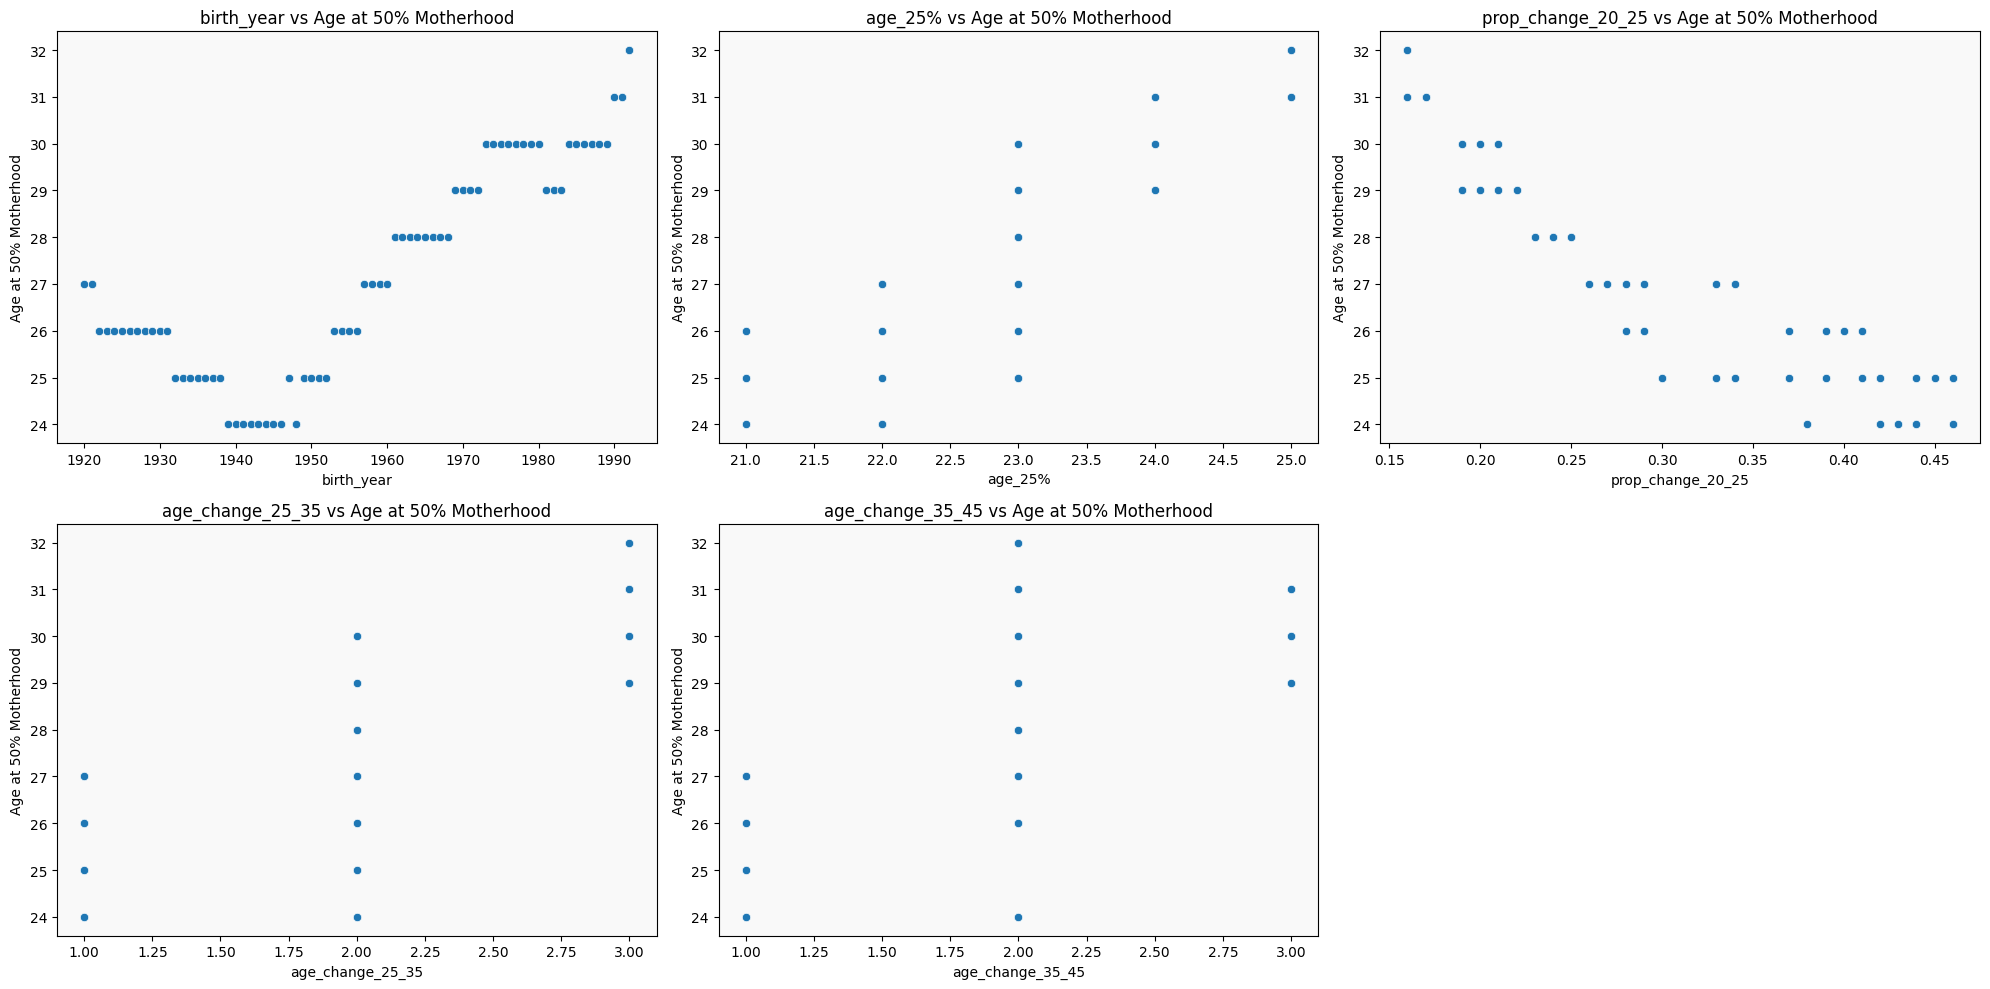

In [34]:
# Plotting features v target

features = ['birth_year', 'age_25%', 'prop_change_20_25', 'age_change_25_35', 'age_change_35_45']
target = 'age_50%'

n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize = (20, 5 * n_rows))
fig.subplots_adjust(hspace = 0.6, wspace = 0.6)
axes = axes.flatten()

for i, feature in enumerate(features):
    temp_df = model_df[[feature, target]]
    sns.scatterplot(x = temp_df[feature], y = temp_df[target], ax = axes[i])
    axes[i].set_title(f'{feature} vs Age at 50% Motherhood')
    axes[i].set_ylabel('Age at 50% Motherhood')
    axes[i].set_xlabel(feature)

for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show();

# Model Variables and Sets

In [35]:
# Defining input and target variables

X = model_df[features]
y = model_df[target]

In [36]:
# Splittig the data into training, validation and test sets as defined earlier.
# Done manually as random splitting (e.g. TrainTestSplit) not suitable

_by = model_df['birth_year']

train_mask = _by <= 1975
val_mask = (_by >= 1976) & (_by <= 1989)
test_ver_mask = (_by >= 1990) & (_by <= 1992)
test_fore_mask = (_by >= 1993) & (_by <= 2008)

X_train = X[train_mask]
y_train = y[train_mask]
_by_train = model_df.loc[train_mask, 'birth_year']

X_val = X[val_mask]
y_val = y[val_mask]
_by_val = model_df.loc[val_mask, 'birth_year']

X_test_ver = X[test_ver_mask]
y_test_ver = y[test_ver_mask]
_by_test_ver = model_df.loc[test_ver_mask, 'birth_year']

X_test_fore = X[test_fore_mask]
_by_test_fore = model_df.loc[test_fore_mask, 'birth_year']
# y_test_fore are all NaN as birth cohorts have not reached 50% motherhood

# Training the Model

As a baseline, running Random Forest Regressor with default settings.

In [37]:
default_rf = RandomForestRegressor(random_state = 42)
default_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

# Evaluation Metrics & Plots

In [38]:
# Defining a funtion to collate numerical evaluation metrics

def model_performance(y_true, y_pred, model_name):

  mae = mean_absolute_error(y_true, y_pred)

  rmse = root_mean_squared_error(y_true, y_pred)

  # Using floor integers to compare in complete years
  y_true_years = np.floor(y_true).astype(int)
  y_pred_years = np.floor(y_pred).astype(int)
  accuracy_score = (y_true_years == y_pred_years).mean()

  performance = {
      'Mean Absolute Error' : round(mae, 3),
      'Root Mean Square Error' : round(rmse, 3),
      'Accuracy Score' : round((100* accuracy_score), 3)
  }

  return performance

In [81]:
# Defining a function to collate visualisations of residual diagnostics

def plot_diagnostics(
    y_true,
    y_pred,
    model_name,
    x_range = None,
    importances = None,
    feature_names = None,
    model_title = 'Model'
    ):

  residuals = y_pred - y_true # Positive residual for overestimate

  fig, axs = plt.subplots(3, 2, figsize = (15, 18))
  plt.suptitle(f'{model_title} Diagnostics')

  # 1 Feature importances

  if importances is not None and feature_names is not None:

    sns.barplot(x = importances,
                y = feature_names,
                ax = axs[0,0])
    axs[0,0].set_title('1. Feature Importances')
    axs[0,0].set_xlabel('Importance')
    axs[0,0].set_ylabel('Features')

  else:

    axs[0,0].axis('off')

  # 2 Predictions v True

  sns.scatterplot(x = y_true,
                  y = y_pred,
                  ax = axs[0,1])

  lims = [
    np.min([y_true.min(), y_pred.min()]),
    np.max([y_true.max(), y_pred.max()])]

  axs[0,1].plot(lims, lims, 'r--', label = 'Perfect prediction')
  axs[0,1].legend()
  axs[0,1].set_title('2. Predicted vs True Age of 50% Motherhood')
  axs[0,1].set_xlabel('True Age')
  axs[0,1].set_ylabel('Predicted Age')

  # 3 Residuals Distribution (with 0 line)

  sns.histplot(residuals,
               kde = True,
               ax = axs[1,0])
  mn = residuals.mean()
  axs[1,0].axvline(0, color = 'red', linestyle = '--', label ='Zero')
  axs[1,0].axvline(mn, color = 'green', linestyle = '--', label ='Mean')
  axs[1,0].legend()
  axs[1,0].set_xlabel('Residual')
  axs[1,0].set_ylabel('Frequency Density')
  axs[1,0].set_title('3. Residual Distribution')


  # 4 Residuals v Predictions

  sns.scatterplot(x = y_pred,
                  y = residuals,
                  ax = axs[1, 1])
  axs[1,1].axhline(0, color='red', linestyle = '--')
  axs[1,1].set_ylabel('Residual')
  axs[1,1].set_xlabel('Predicted Age')
  axs[1,1].set_title('4. Residuals vs Predicted Age of 50% Motherhood')

  # 5 Residuals over time

  sns.lineplot(x = x_range,
             y = residuals,
             marker = 'X',
             ax = axs[2,0])
  axs[2,0].axhline(0, color='red', linestyle='--')
  axs[2,0].set_xlabel('Birth Year')
  axs[2,0].set_ylabel('Residual')
  axs[2,0].set_title('5. Residuals over Birth Years')

  # 6 Precited & True over time using COMPLETE YEARS for functionality

  # Using floor integers to compare in complete years
  y_true_years = np.floor(y_true).astype(int)
  y_pred_years = np.floor(y_pred).astype(int)

  sns.lineplot(
    x = x_range,
    y = y_true_years,
    label = 'True',
    marker = 'X',
    ax = axs[2,1])

  sns.lineplot(
      x = x_range,
      y = y_pred_years,
      label = 'Predicted',
      marker = 'o',
      ax = axs[2,1])

  axs[2,1].set_xlabel('Birth Year')
  axs[2,1].set_ylabel('Age at 50% Motherhood')
  axs[2,1].set_title(f'6. Predicted and True Age (in Complete Years) over Birth Year')

  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

# Evaluating the Default Random Forest Regressor

In [82]:
# Using the default random forest regressor to predict on the validation set.

y_val_pred_drf = default_rf.predict(X_val)

In [83]:
default_rf_performance = model_performance(y_val, y_val_pred_drf, default_rf)
default_rf_performance

{'Mean Absolute Error': 0.291,
 'Root Mean Square Error': 0.47,
 'Accuracy Score': np.float64(64.286)}

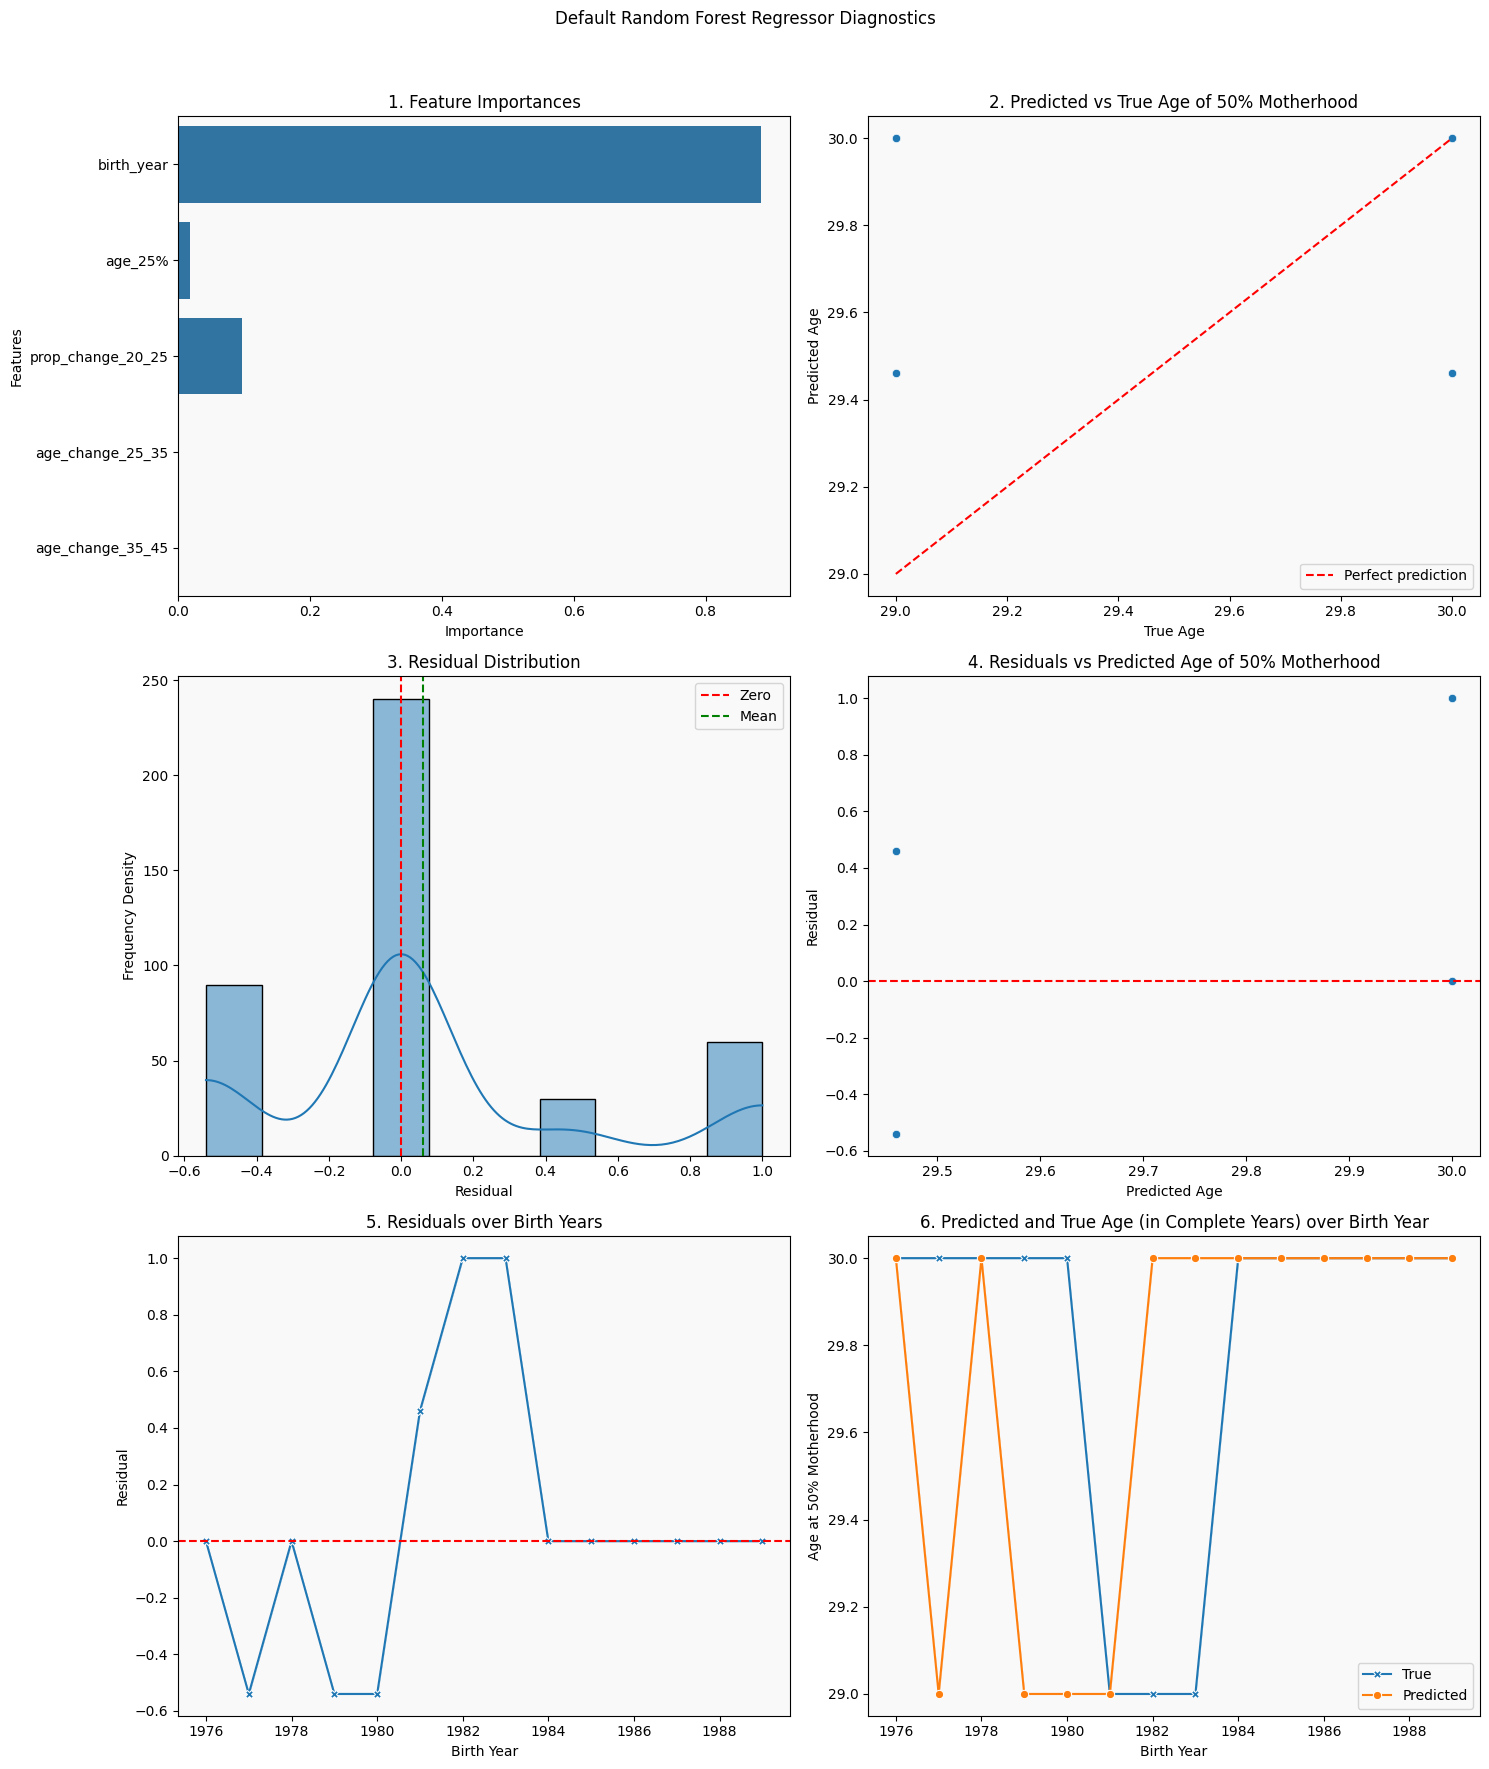

In [84]:
plot_diagnostics(
    y_val,
    y_val_pred_drf,
    default_rf,
    _by_val,
    importances = default_rf.feature_importances_,
    feature_names = X_train.columns,
    model_title = 'Default Random Forest Regressor'
)

# Tuning the Randon Forest Regressor

Using RandomizedSearch for hyperparameters and TimeSeriesSplit for cross-validaiton in re-training.

In [43]:
param_dist = {
    'n_estimators' : [50, 100, 150, 200],
    'max_depth' : [None, 5, 10, 20],
    'min_samples_split' : [2, 4, 5],
    'min_samples_leaf' : [1, 2, 3],
    'max_features' : [2, 3, 5],
    'bootstrap' : [True, False]
}


# TimeSeriesSplit with 4 folds

tscv = TimeSeriesSplit(n_splits = 4)

# RandomizedSearch inspection of range of hyperparameters

random_search = RandomizedSearchCV(
    estimator = RandomForestRegressor(random_state = 42),
    param_distributions = param_dist,
    n_iter = 30,
    scoring = 'neg_mean_absolute_error', # neg as lower means worse in search
    cv = tscv,
    random_state = 42,
    n_jobs = -1
)

# numer of search fits:
# 4*4*3*3*3*2*4

In [44]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
                   estimator=RandomForestRegressor(random_state=42), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 5, 10, 20],
                                        'max_features': [2, 3, 5],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 4, 5],
                                        'n_estimators': [50, 100, 150, 200]},
                   random_state=42, scoring='neg_mean_absolute_error')

In [45]:
tuned_rf = random_search.best_estimator_
tuned_rf

RandomForestRegressor(bootstrap=False, max_depth=10, max_features=5,
                      n_estimators=50, random_state=42)

In [46]:
tuned_params = random_search.best_params_
tuned_params

{'n_estimators': 50,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 5,
 'max_depth': 10,
 'bootstrap': False}

# Evaluating the Tuned Random Forest Regressor

In [47]:
y_val_pred_trf = tuned_rf.predict(X_val)

In [48]:
tuned_rf_performance = model_performance(y_val, y_val_pred_trf, tuned_rf)
tuned_rf_performance

# Tiny improvement in error, same accuracy

{'Mean Absolute Error': 0.283,
 'Root Mean Square Error': 0.46,
 'Accuracy Score': np.float64(64.286)}

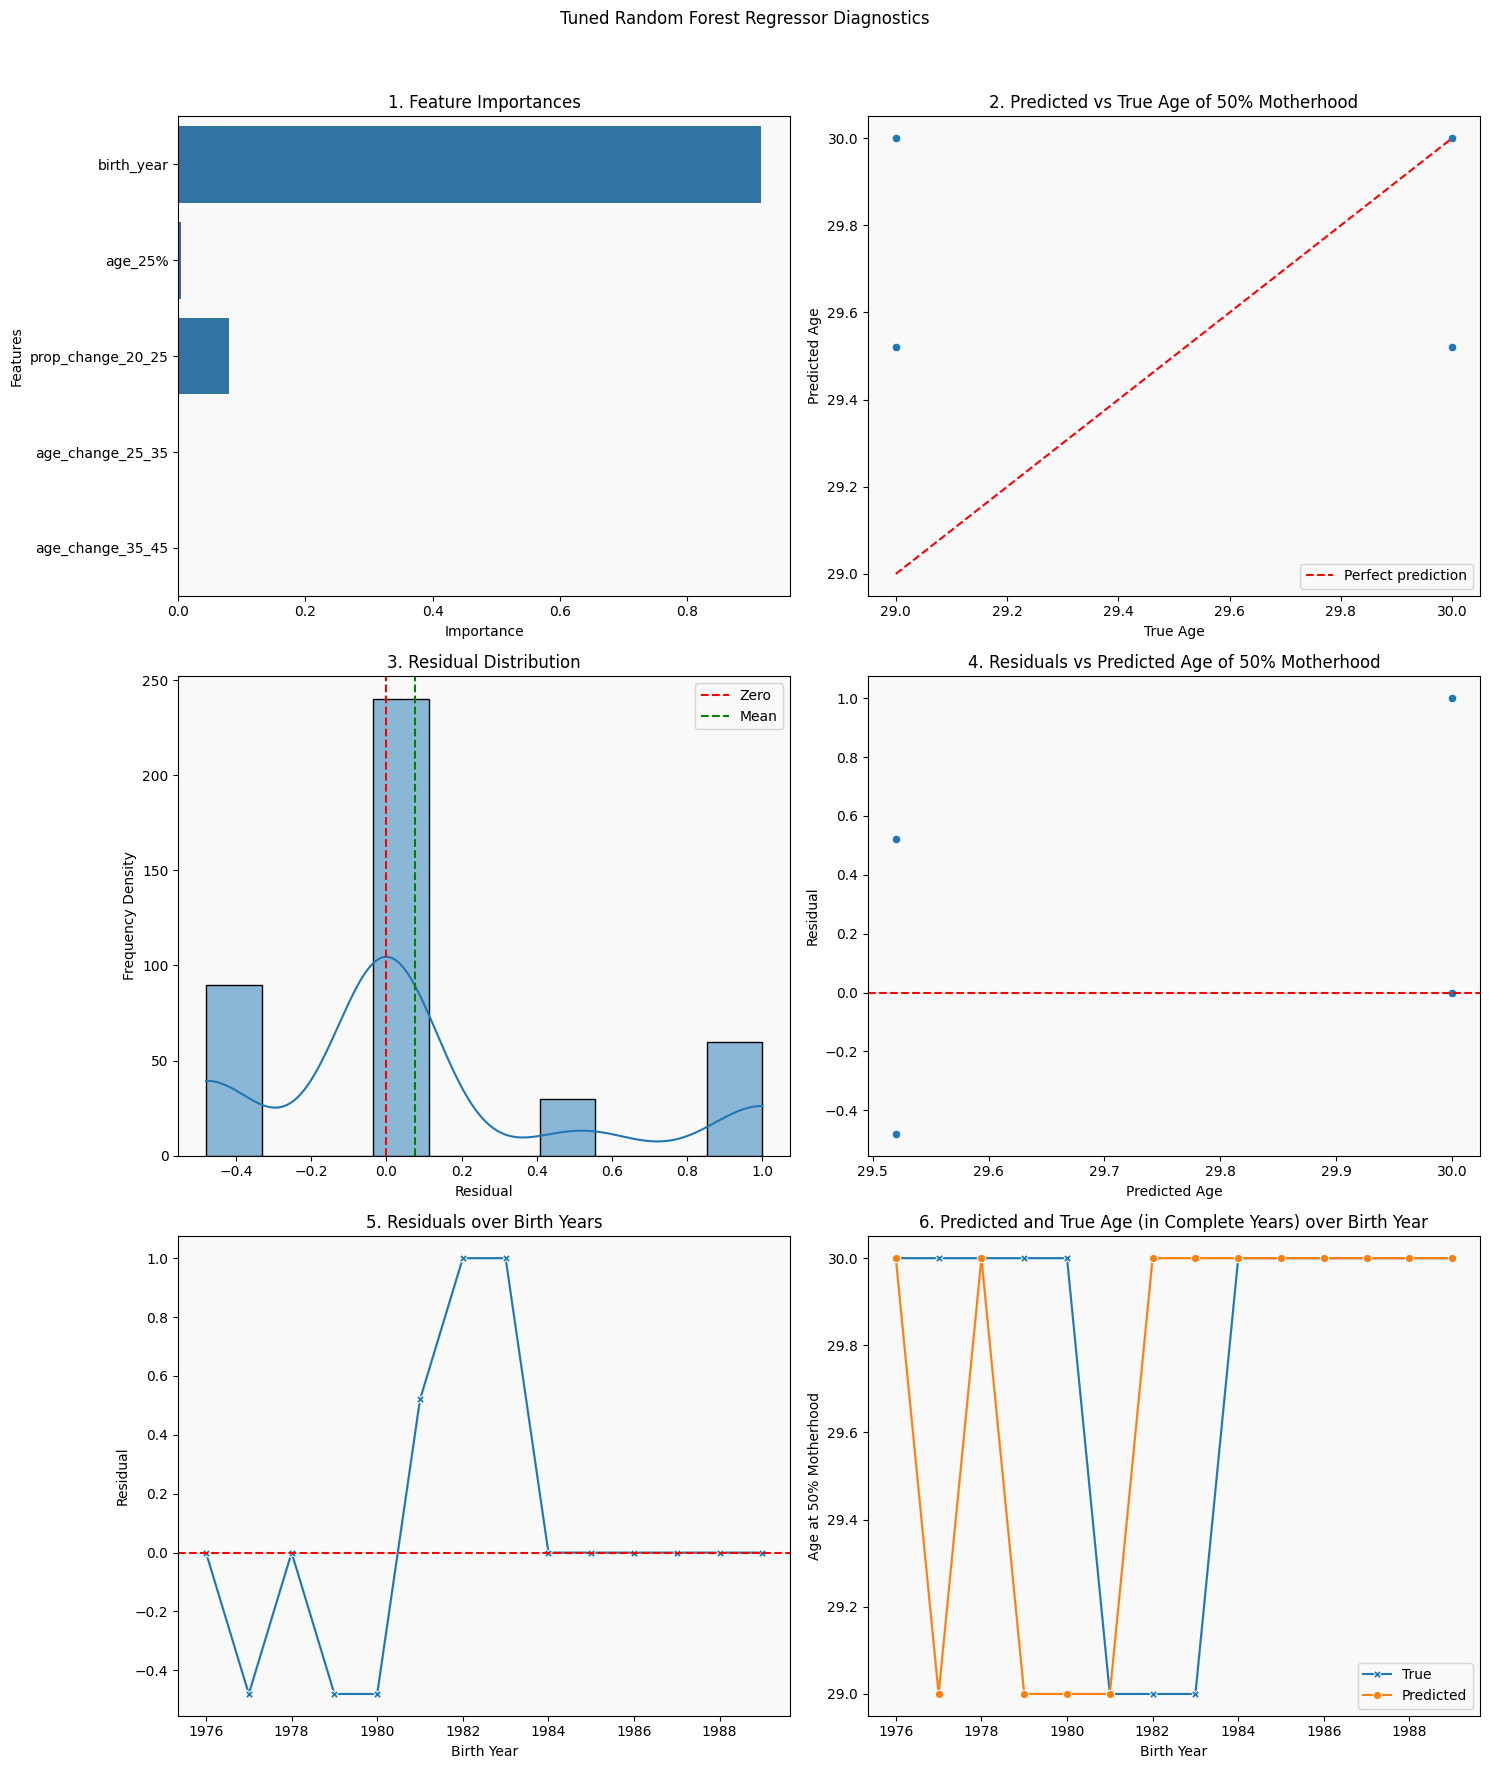

In [49]:
plot_diagnostics(
    y_val,
    y_val_pred_trf,
    tuned_rf,
    _by_val,
    importances = tuned_rf.feature_importances_,
    feature_names = X_train.columns,
    model_title = 'Tuned Random Forest Regressor'
)

# Re-tuning to Mitigate Over-Fitting

Since the discarded wide gridsearch model performed worse than the default, overfitting was suspected.

To address this:
1. Investigating hyperparameters  `max_depth` and `min_samples_leaf ` to reduce the complexity of the model. Using gridsearch as very small range to try and so can afford exhaustive search. (Bootstrapping default back to True. Worth investigating False to make the most of small training dataset but perhaps needed to increase diversity of trees and make ensemble stronger.)

2. Investigating whether fewer folds in the TimeSeriesSplit may improve generalisation. Potential since this will increase the amount of data in each fold, reducing overfitting to early samples and increasing signal from later trends.

In practise, both trials returned the default model as best estimator and so are commented out here for efficiency.

In [51]:
# # Redcued gridsearch

# new_param_dist = {
#     'max_depth' : [None, 5, 10],
#     'min_samples_leaf' : [1, 2, 3]
# }

# # Keep TimeSeriesSplit with 4 folds

# tscv = TimeSeriesSplit(n_splits = 4)

# # GridSearch thorough inspection of relatively small range of hyperparameters

# new_grid_search = GridSearchCV(
#     estimator = RandomForestRegressor(random_state = 42),
#     param_grid = new_param_dist,
#     scoring = 'neg_mean_absolute_error', # neg as lower means worse in gridsearch
#     cv = tscv,
#     n_jobs = -1
# )

In [52]:
# new_grid_search.fit(X_train, y_train)

In [53]:
# retuned_rf = new_grid_search.best_estimator_
# retuned_rf

In [54]:
# retuned_params = new_grid_search.best_params_
# retuned_params

# # Oh this is the same as the default!

In [55]:
# # Try TimeSeriesSplit with 3 folds

# new_tscv = TimeSeriesSplit(n_splits = 3)

# # GridSearch thorough inspection of relatively small range of hyperparameters

# final_grid_search = GridSearchCV(
#     estimator = RandomForestRegressor(random_state = 42),
#     param_grid = new_param_dist,
#     scoring = 'neg_mean_absolute_error', # neg as lower means worse in gridsearch
#     cv = new_tscv,
#     n_jobs = -1
# )

In [56]:
# final_grid_search.fit(X_train, y_train)

In [57]:
# fintuned_rf = final_grid_search.best_estimator_
# fintuned_rf

In [58]:
# fintuned_params = final_grid_search.best_params_
# fintuned_params

# This is the default again, performing exactly as well.

# Investigating Gradient Boosting

Graident Boosting trialled as an alternative ensemble method to Random Forest. In practise, both trials saw no functional improvement in performance so commented out here for efficiency.

First trialled default GraidentBoostingRegressor - lower MAE and RMSE misleading as accuracy collapsed. Plotting revealed the gb model predicting single value for target, so underfitting. Attempted to mitigate this using randomized search to increase estimators and reduce learning rate, but no improvement seen.

Unfortunately, don't have the time needed to better tune this model in order to see the benefit.


In [59]:
# gb = GradientBoostingRegressor(
#     n_estimators = 100,
#     max_depth = 3,
#     learning_rate = 0.1,
#     random_state = 42
# )

# gb_model = gb.fit(X_train, y_train)

# y_val_pred_gb = gb.predict(X_val)

In [60]:
# gb_performance = model_performance(y_val, y_val_pred_gb, gb_model)
# gb_performance

# Marginally lower MAE and RMSE slightly misleading as functional accuracy has collapsed.

In [61]:
# plot_diagnostics(
#     y_val,
#     y_val_pred_gb,
#     gb_model,
#     x_range = _by_val,
#     importances = gb_model.feature_importances_,
#     feature_names = X_train.columns,
#     model_title = 'Benchmark Gradient Boosting Regressor'
# )

# Plots explian this, as model is predicting constant value.

In [62]:
# param_dist = {
#     'n_estimators' : [100, 200, 300, 400, 500],
#     'max_depth' : [None, 3, 5],
#     'learning_rate' : [0.01, 0.03, 0.05]
# }


# # TimeSeriesSplit with 4 folds

# tscv = TimeSeriesSplit(n_splits = 4)

# # RandomizedSearch inspection of range of hyperparameters

# random_gb_search = RandomizedSearchCV(
#     estimator = GradientBoostingRegressor(random_state = 42),
#     param_distributions = param_dist,
#     n_iter = 20,
#     scoring = 'neg_mean_absolute_error',
#     cv = tscv,
#     random_state = 42,
#     n_jobs = -1
# )

In [63]:
# random_gb_search.fit(X_train, y_train)

In [64]:
# tuned_gb = random_gb_search.best_estimator_
# tuned_gb

In [65]:
# random_gb_search.best_params_

In [66]:
# y_pred_tgb = tuned_gb.predict(X_val)

In [67]:
# model_performance(y_val, y_pred_tgb, tuned_gb)

# Comparing the Random Forest Regressors

In [68]:
default_rf_performance['Model'] = 'Default Random Forest'
tuned_rf_performance['Model'] = 'Tuned Random Forest'

performance_list = [
    default_rf_performance,
    tuned_rf_performance
]

performance_df = pd.DataFrame(performance_list)

cols = ['Model'] + [col for col in performance_df.columns if col != 'Model']
performance_df = performance_df[cols]

performance_df_sorted = performance_df.sort_values(by = 'Mean Absolute Error', ascending = True)

performance_df_sorted

,Model,Mean Absolute Error,Root Mean Square Error,Accuracy Score
1,Tuned Random Forest,0.283,0.46,64.286
0,Default Random Forest,0.291,0.47,64.286


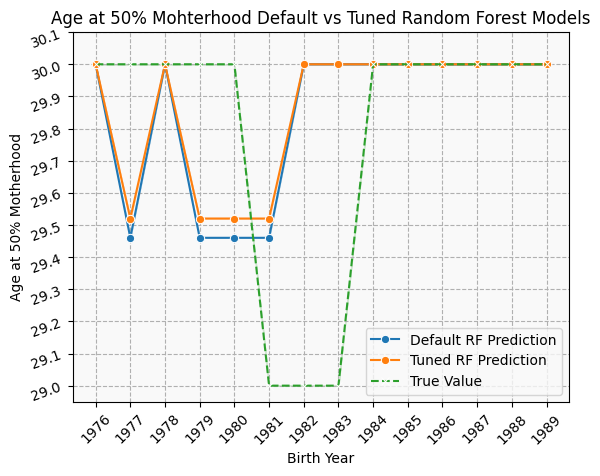

In [50]:
# Plot comparing default and tuned predictions

sns.lineplot(
    x = _by_val,
    y = y_val_pred_drf,
    label = 'Default RF Prediction',
    marker = 'o')

sns.lineplot(
    x = _by_val,
    y = y_val_pred_trf,
    label = 'Tuned RF Prediction',
    marker = 'o')

sns.lineplot(
    x = _by_val,
    y = y_val,
    label = 'True Value',
    marker = 'x',
    linestyle = '--')

plt.title('Age at 50% Mohterhood Default vs Tuned Random Forest Models')
plt.xlabel('Birth Year')
plt.ylabel('Age at 50% Motherhood')

plt.xticks(range(1976, 1990), rotation = 45)
plt.yticks(np.arange(29, 30.1, 0.1), rotation = 20)
plt.grid(linestyle = '--')

plt.legend()
plt.show()

# Testing the Best Model

In [69]:
best_rf = tuned_rf

In [70]:
test_ver_pred = best_rf.predict(X_test_ver)

In [71]:
model_performance(y_test_ver, test_ver_pred, best_rf)

# Not a good performance, but only 3 years.
# Suggests the problem in recent cohorts being so different.
# 31 and 32 not yet seen by the model as plausible values for target variable.

{'Mean Absolute Error': 1.333,
 'Root Mean Square Error': 1.414,
 'Accuracy Score': np.float64(0.0)}

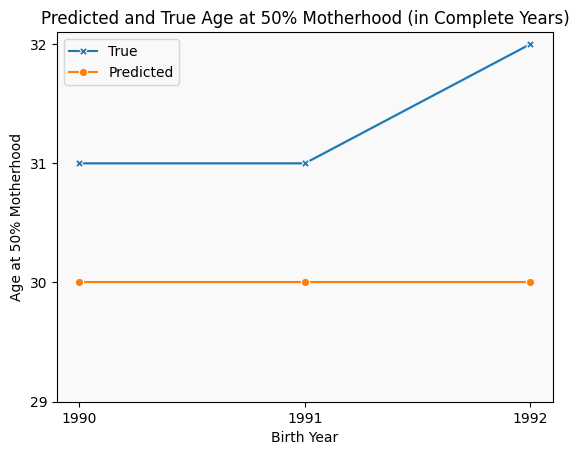

In [72]:
# Plot to examine differences

ver_true_years = np.floor(y_test_ver).astype(int)
ver_pred_years = np.floor(test_ver_pred).astype(int)

sns.lineplot(
  x = _by_test_ver,
  y = ver_true_years,
  label = 'True',
  marker = 'X'
  )

sns.lineplot(
  x = _by_test_ver,
  y = ver_pred_years,
  label = 'Predicted',
  marker = 'o'
          )

plt.xticks(range(1990, 1993))
plt.yticks(range(29, 33))

plt.xlabel('Birth Year')
plt.ylabel('Age at 50% Motherhood')
plt.title('Predicted and True Age at 50% Motherhood (in Complete Years)')

plt.show()

# Forecasting

Unfortunately, though the tuned model performed best on the validation set, it has not predicted well on the verifiable test set.

This is likely due to the shifting pattern in recent cohorts and there not being enough available data to expose the model to this in training/validation.

This is still the best available model and so is used to make predictions on the forecast test set. However, these predictions must be interpreted with caution as the verifiable test shows that the model is unlikely to be accurate in these more recent cohorts.

In [73]:
test_fore_pred = best_rf.predict(X_test_fore)

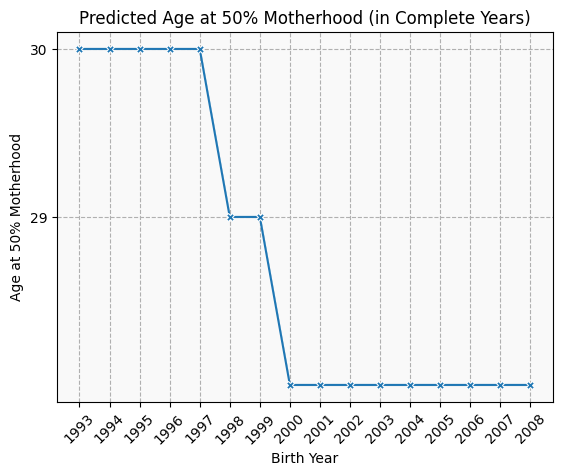

In [74]:
# Plot of forecasts

fore_pred_years = np.floor(test_fore_pred).astype(int)

sns.lineplot(
  x = _by_test_fore,
  y = fore_pred_years,
  marker = 'X'
  )

plt.xticks(range(1993, 2009), rotation = 45)
plt.yticks(range(29, 31))
plt.grid(linestyle = '--')

plt.xlabel('Birth Year')
plt.ylabel('Age at 50% Motherhood')
plt.title('Predicted Age at 50% Motherhood (in Complete Years)')

plt.show()

# Oh dear.

# Countering with ONS Predictions


In [75]:
# Using table 1b of ONS predictions of average number of live born children by age and birth cohort

avg_no_child = pd.read_excel('final2023tables.xlsx', sheet_name = 'Table 1b', header = 8)

def convert_col_names(col):
  if col.isdigit():
    return int(col)
  elif col == 'Age exact years - 16 [note 4]':
    return(16)
  elif col == 'Year of birth of woman [note 7]':
    return('Birth Year')
  elif col == 'Proportion of women having had no children [note 8]':
    return('Proportion Childless')
  else:
    return col

avg_no_child.columns = [convert_col_names(col) for col in avg_no_child.columns]

# Predictions of my model are poor from 1990 onwards.
# True ages 31 and 32 are predicted 30, 29 and 28.
# So interested in these portions of the table for forecasts.

# 1976 - 1989 cohorts did reach 50% motherhood at 29 or 30.
# So interested in these cohorts for comparison

keep_cols = ['Birth Year', 28, 29, 30, 31, 32]
cohorts = list(range(1976, 2009))
interested_in = avg_no_child['Birth Year'].isin(cohorts)

avg_no_child = avg_no_child[keep_cols][interested_in]

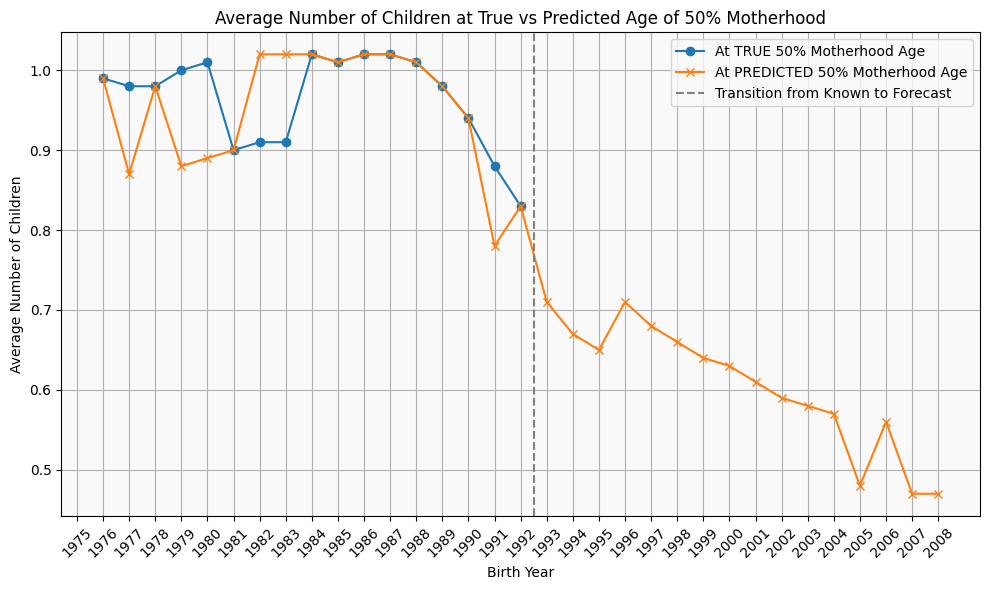

In [76]:
# Using this to plot avg no child for true 50% motherhood 1976-1992
# and avg no child for predicted 50% motherhood 1976-2008

true_years = list(range(1976, 1993))
all_years = list(range(1976, 2009))

true_avg_vals = []
for year, age in zip(true_years, y_val.tolist() + y_test_ver.tolist()):
    age_int = np.floor(age)
    row = avg_no_child[avg_no_child['Birth Year'] == year]
    true_avg_vals.append(row[age_int].values[0])


pred_avg_vals = []
for year, age in zip(all_years, y_val_pred_trf.tolist() + test_ver_pred.tolist() + test_fore_pred.tolist()):
    age_int = np.floor(age)
    row = avg_no_child[avg_no_child['Birth Year'] == year]
    pred_avg_vals.append(row[age_int].values[0])


plt.figure(figsize = (10, 6))

plt.plot(true_years,
         true_avg_vals,
         label = 'At TRUE 50% Motherhood Age',
         marker = 'o')

plt.plot(all_years,
         pred_avg_vals,
         label = 'At PREDICTED 50% Motherhood Age',
         marker = 'x')

plt.axvline(1992.5, linestyle = '--', color = 'grey', label = 'Transition from Known to Forecast')

plt.title('Average Number of Children at True vs Predicted Age of 50% Motherhood')
plt.xlabel('Birth Year')
plt.ylabel('Average Number of Children')

plt.grid()
plt.xticks(range(1975, 2009), rotation = 45)
plt.legend()

plt.tight_layout()
plt.show()

# Saving the Model

Saving the model for future use (maybe as a bad example? 🤣)

In [77]:
model_name = 'best_rf.joblib'

joblib.dump(best_rf, model_name)

print(f"Model saved to {model_name}")

Model saved to best_rf.joblib


In [78]:
# Using load to check

loaded_model = joblib.load('best_rf.joblib')

loaded_model.feature_importances_

array([0.91587598, 0.00497409, 0.07914993, 0.        , 0.        ])